# **🌿 COS30082 Applied Machine Learning**  <br> **🧠 ML Group Project**
---
## **Cross Domain Plant Species Identification <br> (PlantCLEF 2020)**

**Prepared by:** VerdantVision (Group 2)
- Deron Yijia FOO (102780757)  
- Esther Hui Min CHAI (102778419)
- Jayne Hieng Siew WONG (102776536)
- Jun Hong LAI (102780715)
- William Chin Lee WAN (10435387)

**Prepared for:** Ts Dr Lee Sue Han  

**Due Date**: 28 November 2025 by 23:59

*Semester 2, 2025*

---

#**1.0 🧩 Setup and Configuration**

> This first section sets up the environment by preparing storage, installing dependencies, importing libraries, and configuring reproducibility for consistent deep-learning experimentation.

In [ ]:
# --- 1️⃣ Environment Setup ---
from google.colab import drive
import os  # Standard library for interacting with the operating system.
import sys

# Mount Google Drive (for persistent storage of models/logs)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("✅ Google Drive already mounted.")

✅ Google Drive already mounted.


In [ ]:
# Create setup directory
os.makedirs("setup", exist_ok=True)

# Define requirements
requirements = """\
# ==================================
# Core Deep Learning Framework
# ==================================
torch
torchvision
torchaudio
accelerate

# ==================================
# Data Manipulation & Analysis
# ==================================
datasets
numpy
pandas
scikit-learn

# ==================================
# Computer Vision & Image Processing
# ==================================
Pillow
opencv-python

# ==================================
# Model Architectures & Analysis
# ==================================
timm
torchsummary
transformers

# ==================================
# Visualisation & Plotting
# ==================================
matplotlib
seaborn
tabulate

# ==================================
# System & Utility Tools
# ==================================
tqdm
gdown
psutil
"""

# Generate the requirements file with dependencies categorised by function.
with open("setup/requirements.txt", "w") as f:
    f.write(requirements)

print("✅ requirements.txt successfully created!")

✅ requirements.txt successfully created!


In [ ]:
# --- 2️⃣ Dependency Installation ---
# Install all categorised libraries listed in the requirements file silently.
!pip install -r setup/requirements.txt --quiet

print("✅ All required packages installed successfully.")

✅ All required packages installed successfully.


In [ ]:
# --- 3️⃣ Import Libraries ---

# ⚙️ System & File Handling
import csv
import time
import math
import re
import random
import tarfile
import zipfile
import pickle
import json
import shutil
import psutil
from pathlib import Path
from collections import OrderedDict, defaultdict
from typing import List
import argparse
import importlib

# 📊 Data Manipulation
import numpy as np
import pandas as pd
from tabulate import tabulate
import gdown
from tqdm.auto import tqdm

# 🎨 Visualisation
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from PIL import Image

# 🧠 PyTorch & Deep Learning Core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torch.cuda.amp import autocast
from torch.amp import GradScaler # Mixed precision
from torch.autograd import Function

# 🖼️ Computer Vision
import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T
import cv2

# 🧬 Model Architectures
import timm # PyTorch Image Models (state-of-the-art architectures)
from transformers import AutoModel, get_cosine_schedule_with_warmup

# 📈 Metrics & Evaluation
from sklearn.metrics import (
    accuracy_score, top_k_accuracy_score, confusion_matrix,
    classification_report, precision_recall_fscore_support,
    precision_score, recall_score, f1_score, balanced_accuracy_score
)
from sklearn.preprocessing import LabelEncoder

In [ ]:
# --- 4️⃣ Reproducibility and Hardware ---

def set_seed(seed=42):
    """Sets global seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"✅ Random seed set to: {seed}")

# Set Global Seed
SEED = 42
set_seed(SEED)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# System Check
print("="*40)
print(f"🚀 System Configuration")
print(f"   Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"   CPU Cores: {psutil.cpu_count(logical=True)}")
print(f"   Torch: {torch.__version__}")
print(f"   Timm: {timm.__version__}")
print("="*40)

✅ Random seed set to: 42
🚀 System Configuration
   Device: cuda
   GPU: NVIDIA A100-SXM4-40GB
   VRAM: 42.47 GB
   CPU Cores: 12
   Torch: 2.9.0+cu126
   Timm: 1.0.22


# **2.0 📦 Dataset Handling**

> This second section prepares the dataset for modelling by extracting the files locally, establishing global class mappings, analysing key challenges such as domain shift and class imbalance, and defining the full preprocessing and dataset-loading pipeline used across all models.

## &emsp;&emsp;**2.1 🗃️ Data Loading and Global Configuration**

> This section extracts the dataset to the local environment for speed and establishes the global class mappings used by all subsequent models.

In [ ]:
# --- 🧩 0️⃣ Configuration & Fallback ---
# Public file ID for the dataset (Fallback if Drive file is missing)
zip_file_id = "1QHfKNWeVvuP7X0v87w5jgTqpjzZGvGT7"
zip_file_id_url = f"https://drive.google.com/uc?id={zip_file_id}"

# --- 1️⃣ Define Paths ---
# The team uses local /content/data for training speed (faster I/O than Drive)
drive_base = "/content/drive/MyDrive/ML Project"
zip_name = "AML_project_herbarium_dataset.zip"
zip_path_drive = os.path.join(drive_base, zip_name)
zip_path_local = os.path.join("/content", zip_name) # Local fallback path

extract_dir = "/content/data"
list_dir = os.path.join(extract_dir, "list")

# Ensure Drive directory exists
os.makedirs(drive_base, exist_ok=True)

# --- 2️⃣ Dataset Extraction  ---
if not os.path.exists(list_dir):
    print("📂 Dataset not found locally. Checking sources...")

    # Strategy: Check Drive -> If missing, Download to Local -> Extract
    source_zip = None

    if os.path.exists(zip_path_drive):
        print(f"✅ Found dataset in Drive: {zip_path_drive}")
        source_zip = zip_path_drive
    else:
        print(f"⚠️ Dataset not in Drive. Downloading from public link...")
        gdown.download(zip_file_id_url, zip_path_local, quiet=False)
        source_zip = zip_path_local

    print(f"📦 Extracting {source_zip} to {extract_dir}...")
    with zipfile.ZipFile(source_zip, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
    print("✅ Extraction complete.")
else:
    print("✅ Dataset already extracted and ready.")

✅ Dataset already extracted and ready.


In [ ]:
# --- 3️⃣ Load Annotations & Create Global Mappings ---

def load_txt_list(file_path, columns):
    """Helper to load space/semicolon separated text files."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Missing required file: {file_path}")
    # Handle both space (train/test) and semicolon (species_list) separators
    sep = ';' if 'species_list' in file_path else ' '
    return pd.read_csv(file_path, sep=sep, header=None, names=columns)

# A. Load Species List to create mappings
# This establishes the 'Source of Truth' for class indexing across all models.
species_df = load_txt_list(os.path.join(list_dir, "species_list.txt"), ["class_id", "species_name"])
species_df["class_id"] = species_df["class_id"].astype(int)

# Global Constants
NUM_CLASSES = len(species_df)
ALL_CLASS_IDS = sorted(species_df["class_id"].unique())

# Mappings: Class ID (Bio) <-> Model Index (0-99)
CLASS_TO_IDX = {class_id: idx for idx, class_id in enumerate(ALL_CLASS_IDS)}
IDX_TO_CLASS = {idx: class_id for class_id, idx in CLASS_TO_IDX.items()}

print(f"🌿 Global Configuration:")
print(f"   Total Classes: {NUM_CLASSES}")
print(f"   Class Mapping Created (Example: ID {ALL_CLASS_IDS[0]} -> Index 0)")

# B. Load Train and Test Dataframes
train_df = load_txt_list(os.path.join(list_dir, "train.txt"), ["image_path", "class_id"])
# We load groundtruth.txt for test because it contains the labels needed for evaluation
test_df = load_txt_list(os.path.join(list_dir, "groundtruth.txt"), ["image_path", "class_id"])

# Map class_ids to model indices immediately
train_df['label_idx'] = train_df['class_id'].map(CLASS_TO_IDX)
test_df['label_idx'] = test_df['class_id'].map(CLASS_TO_IDX)

# C. Load With/Without Pairs Lists
# We convert these to sets for fast O(1) lookups during evaluation
with_pairs_df = pd.read_csv(os.path.join(list_dir, "class_with_pairs.txt"), header=None, names=["class_id"])
without_pairs_df = pd.read_csv(os.path.join(list_dir, "class_without_pairs.txt"), header=None, names=["class_id"])

WITH_PAIRS_IDS = set(with_pairs_df["class_id"].values)
WITHOUT_PAIRS_IDS = set(without_pairs_df["class_id"].values)

🌿 Global Configuration:
   Total Classes: 100
   Class Mapping Created (Example: ID 12254 -> Index 0)


In [ ]:
# --- 4️⃣ Summary Stats ---
print("\n📊 Dataset Statistics:")
print(f"   Train Images:      {len(train_df)}")
print(f"   Test Images:       {len(test_df)}")
print(f"   Classes w/ Pairs:  {len(WITH_PAIRS_IDS)}")
print(f"   Classes w/o Pairs: {len(WITHOUT_PAIRS_IDS)}")
print(f"   Checking Paths:    {train_df.iloc[0]['image_path']} (Train Sample)")


📊 Dataset Statistics:
   Train Images:      4744
   Test Images:       207
   Classes w/ Pairs:  60
   Classes w/o Pairs: 40
   Checking Paths:    train/photo/106461/154340.jpg (Train Sample)


## &emsp;&emsp;**2.2 🔍 Exploratory Data Analysis (EDA)**

> This section analyses the dataset structure to highlight the two main challenges: **Domain Shift** (visual difference between domains) and **Class Imbalance**.

In [ ]:
# --- 1️⃣ Data Enrichment ---
# Extract the 'domain' (Herbarium vs Photo) from the file paths in train_df
# Example path: "train/herbarium/12345/1.jpg" -> domain: "herbarium"

def get_domain(path):
    if "herbarium" in path:
        return "Herbarium"
    elif "photo" in path:
        return "Field (Photo)"
    else:
        return "Unknown"

# Add domain column with string labels initially
train_df["domain"] = train_df["image_path"].apply(get_domain)

# CONVERT DOMAIN STRINGS TO INTEGERS (0 for Herbarium, 1 for Field/Photo)
train_df["domain"] = train_df["domain"].apply(lambda x: HERBARIUM_DOMAIN if "herbarium" in x.lower() else PHOTO_DOMAIN)

# Merge species names for better readability
train_df = train_df.merge(species_df, on="class_id", how="left")
test_df = test_df.merge(species_df, on="class_id", how="left")

print(f"✅ Data enriched. Columns: {train_df.columns.tolist()}")

✅ Data enriched. Columns: ['image_path', 'class_id', 'label_idx', 'domain', 'species_name_x', 'species_name_y']


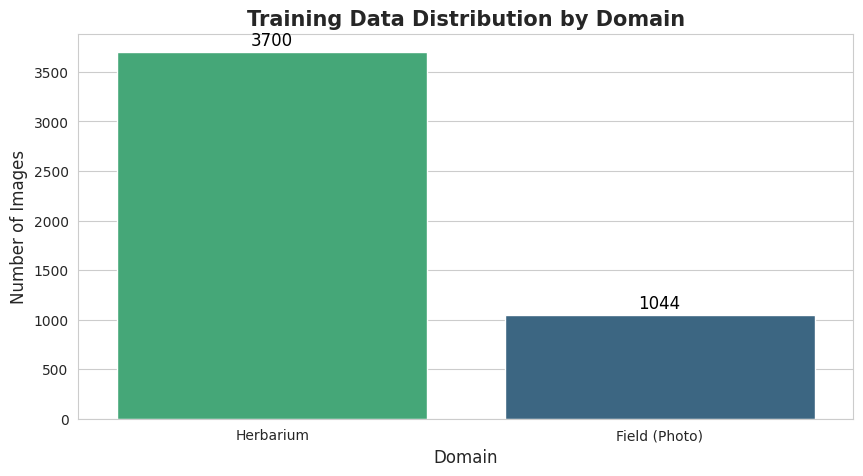

In [ ]:
# --- 2️⃣ Visualisation 1: The Domain Imbalance ---
# This plot highlights the scarcity of field photos compared to herbarium sheets.

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

# Count plot
ax = sns.countplot(
    data=train_df,
    x="domain",
    hue="domain",
    palette="viridis",
    order=["Herbarium", "Field (Photo)"],
    legend=False
)
ax.set_title("Training Data Distribution by Domain", fontsize=15, fontweight='bold')
ax.set_xlabel("Domain", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)

# Add count labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

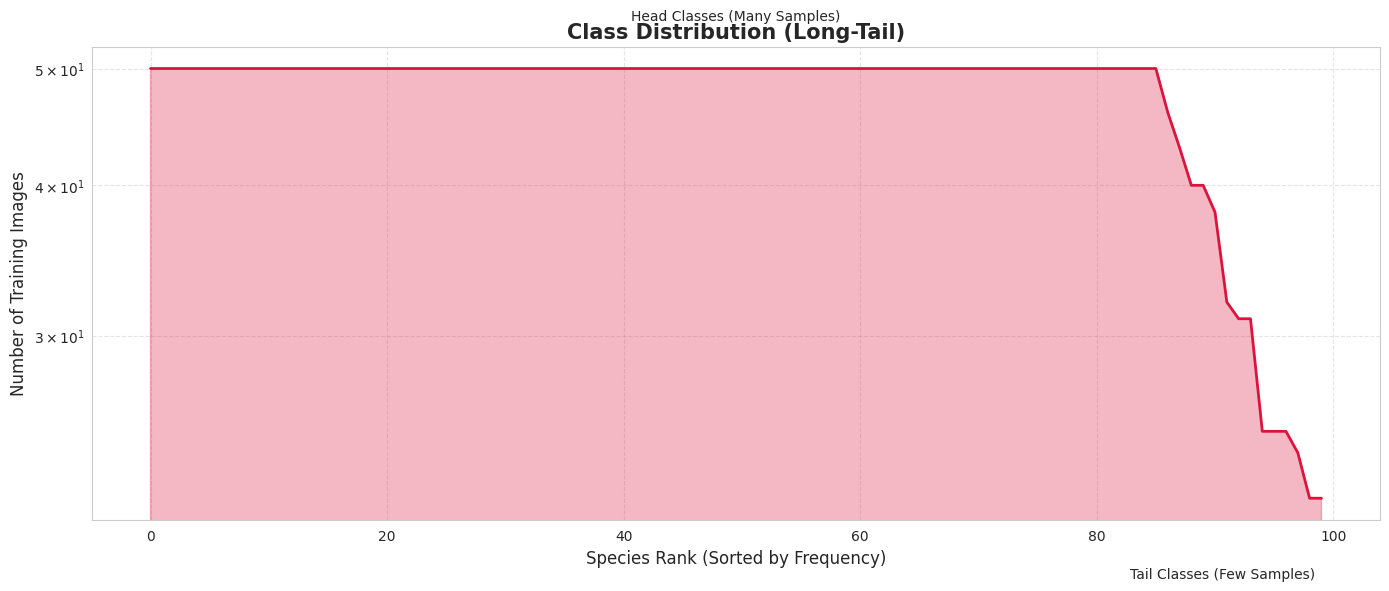

In [ ]:
# --- 3️⃣ Visualisation 2: Long-Tail Class Distribution ---
# This plot proves the dataset is imbalanced (some species have many images, others few).

# Calculate counts per class
class_counts = train_df["class_id"].value_counts().reset_index()
class_counts.columns = ["class_id", "count"]

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
ax = sns.lineplot(data=class_counts, x=range(len(class_counts)), y="count", linewidth=2, color='crimson')
ax.fill_between(range(len(class_counts)), class_counts["count"], alpha=0.3, color='crimson')
plt.title("Class Distribution (Long-Tail)", fontsize=15, fontweight='bold')
plt.xlabel("Species Rank (Sorted by Frequency)", fontsize=12)
plt.ylabel("Number of Training Images", fontsize=12)
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.5)
ax.text(0.5, 1.05, "Head Classes (Many Samples)",
        ha='center', va='bottom', transform=ax.transAxes, fontsize=10)
ax.text(0.95, -0.10, "Tail Classes (Few Samples)",
        ha='right', va='top', transform=ax.transAxes, fontsize=10)
plt.tight_layout()
plt.show()

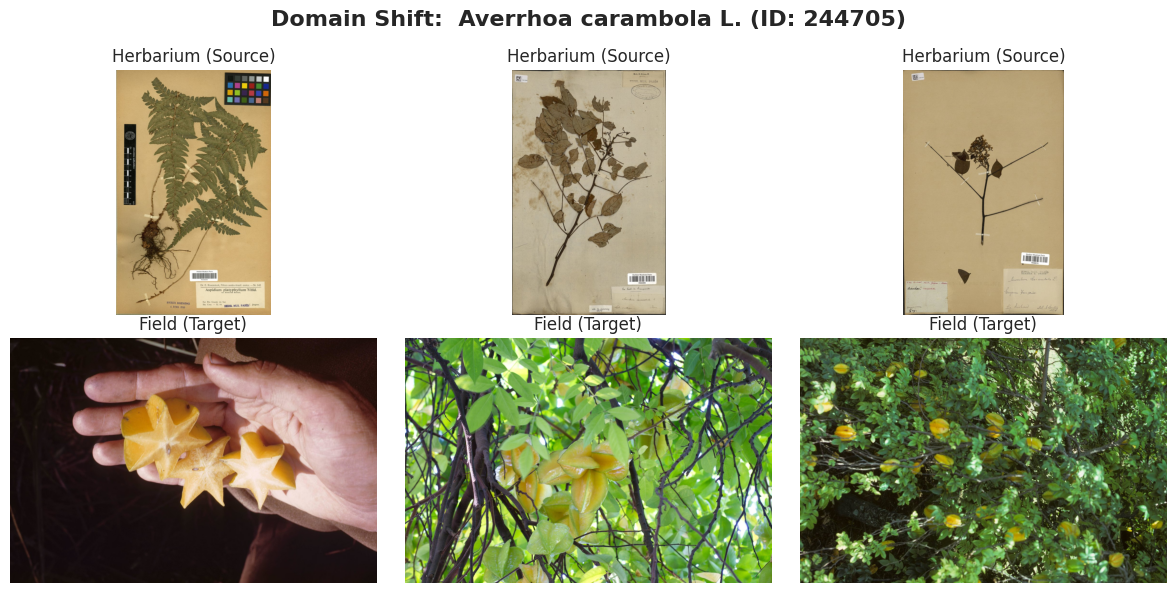

In [ ]:
# --- 4️⃣ Visualisation 3: Visual Domain Shift (The "Eye Test") ---
# We display random samples to show the visual gap between Herbarium sheets and Field photos.

def show_domain_samples(class_id, num_samples=3):
    """Displays Herbarium vs Field images for a specific class."""

    # Filter images for this class
    herb_samples = train_df[(train_df["class_id"] == class_id) & (train_df["domain"] == "Herbarium")].sample(n=min(num_samples, 3), replace=False)
    field_samples = train_df[(train_df["class_id"] == class_id) & (train_df["domain"] == "Field (Photo)")].sample(n=min(num_samples, 3), replace=False)

    # Get species name
    species_name = species_df[species_df["class_id"] == class_id]["species_name"].values[0]

    # Plot
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))
    fig.suptitle(f"Domain Shift: {species_name} (ID: {class_id})", fontsize=16, fontweight='bold')

    # Plot Herbarium Row
    for i in range(num_samples):
        if i < len(herb_samples):
            path = os.path.join(extract_dir, herb_samples.iloc[i]["image_path"])
            img = Image.open(path)
            axes[0, i].imshow(img)
            axes[0, i].set_title("Herbarium (Source)")
            axes[0, i].axis("off")
        else:
            axes[0, i].axis("off") # Hide empty subplots

    # Plot Field Row
    for i in range(num_samples):
        if i < len(field_samples):
            path = os.path.join(extract_dir, field_samples.iloc[i]["image_path"])
            img = Image.open(path)
            axes[1, i].imshow(img)
            axes[1, i].set_title("Field (Target)")
            axes[1, i].axis("off")
        else:
            axes[1, i].text(0.5, 0.5, "No Field Images", ha='center', va='center')
            axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

# Pick a random class that has pairs (so we can see both domains)
if len(WITH_PAIRS_IDS) > 0:
    random_class_id = random.choice(list(WITH_PAIRS_IDS))
    show_domain_samples(random_class_id)
else:
    print("⚠️ No classes with pairs found to visualize.")

## &emsp;&emsp;**2.3 🧼 Data Preprocessing and PyTorch DataLoaders**

> This section defines the image-processing pipeline and dataset loader used to prepare herbarium and field images for all models during training and evaluation.

In [ ]:
# --- 1️⃣ Data Augmentation ---

def get_transforms(model_type='cnn', img_size=224):
    """
    Returns formatting pipeline based on model architecture.
    - CNN (ConvNeXt): Uses RandomResizedCrop for better generalisation.
    - ViT (DINOv2): Uses Resize + CenterCrop to preserve geometry for patch embeddings.
    """
    # Standard ImageNet Normalisation
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]

    if model_type == 'cnn':
        train_tf = transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(norm_mean, norm_std)
        ])
    else: # 'vit' (Vision Transformers like DINOv2)
        train_tf = transforms.Compose([
            transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(img_size),
            transforms.RandomHorizontalFlip(), # Lighter augmentation for ViT fine-tuning
            transforms.ToTensor(),
            transforms.Normalize(norm_mean, norm_std)
        ])

    # Validation/Test is the same for both (Deterministic)
    val_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])

    return train_tf, val_tf

In [ ]:
# --- 2️⃣ Dataset Loader ---

class PlantDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            df (pd.DataFrame): Dataframe with 'image_path' and 'label_idx'
            root_dir (str): Root directory where images are stored
            transform (callable, optional): Optional transform to be applied
        """
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['image_path'])

        # Load Image
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"⚠️ Corrupt image skipped: {img_path}")
            # Return a black image to prevent crash (handled by batch size usually)
            image = Image.new('RGB', (224, 224))

        # Apply Transforms
        if self.transform:
            image = self.transform(image)

        # Get Label (Model Index) and Original Class ID (Bio ID)
        label_idx = torch.tensor(row['label_idx'], dtype=torch.long)

        # Get Domain (0 = Herbarium, 1 = Field)
        # Needed for Approach 3 (DANN). If not in DF, infer from path.
        if 'domain' in row:
            # Handle if domain is string "Herbarium"/"Field" or int 0/1
            d_val = row['domain']
            if isinstance(d_val, str):
                domain_idx = 0 if 'herb' in d_val.lower() else 1
            else:
                domain_idx = int(d_val)
        else:
            # Fallback inference from path
            domain_idx = 0 if 'herbarium' in row['image_path'].lower() else 1

        domain_tensor = torch.tensor(domain_idx, dtype=torch.long)

        # Get Original Class ID (Bio ID for evaluation tracking)
        original_id = row['class_id']

        # Returns: Image, Label, Domain, Original_ID
        return image, label_idx, domain_tensor, original_id

In [ ]:
# --- 3️⃣ DataLoader Setup ---

# Create DataLoaders (Example for Baseline 1 CNN)
BATCH_SIZE = 32
train_tf_cnn, val_tf_cnn = get_transforms(model_type='cnn')

# Datasets
train_dataset = PlantDataset(train_df, extract_dir, transform=train_tf_cnn)
test_dataset = PlantDataset(test_df, extract_dir, transform=val_tf_cnn)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"✅ DataLoaders Ready (Batch Size: {BATCH_SIZE})")
print(f"   Train Steps per Epoch: {len(train_loader)}")
print(f"   Test Steps: {len(test_loader)}")

✅ DataLoaders Ready (Batch Size: 32)
   Train Steps per Epoch: 149
   Test Steps: 7


## &emsp;&emsp;**2.4 🎨 Generative Augmentation (FastCUT)**

> This section trains a generative model to translate **Herbarium (Domain A)** images into **Field (Domain B)** images, specifically for the rare species that lack field data.

In [ ]:
!pip install dominate visdom --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# --- 🛠️ FastCUT Setup & Data Formatting ---

# 1. Install FastCUT Dependencies
print("🎨 Setting up FastCUT environment...")
if not os.path.exists("contrastive-unpaired-translation"):
    !git clone https://github.com/taesungp/contrastive-unpaired-translation.git
    print("✅ Cloned FastCUT repo.")

🎨 Setting up FastCUT environment...
Cloning into 'contrastive-unpaired-translation'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 286 (delta 87), reused 82 (delta 82), pack-reused 170 (from 1)
Receiving objects: 100% (286/286), 17.91 MiB | 11.72 MiB/s, done.
Resolving deltas: 100% (150/150), done.
✅ Cloned FastCUT repo.


In [ ]:
# 2. Prepare Data Folders (A = Herbarium, B = Field)
# FastCUT expects: datasets/plantclef/trainA, trainB, testA, testB
FASTCUT_DATA = "/content/contrastive-unpaired-translation/datasets/plantclef"
dirs = ["trainA", "trainB", "testA", "testB"]

for d in dirs:
    os.makedirs(os.path.join(FASTCUT_DATA, d), exist_ok=True)

print("📂 Organizing data for GAN training...")
count_a, count_b, count_test, count_test_b_dummy = 0, 0, 0, 0

# Iterate our Master DataFrame (train_df) to organize files
# The team will also collect some images for testB from trainB to prevent ZeroDivisionError

train_b_paths = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Sorting Images"):
    src_path = os.path.join(extract_dir, row['image_path'])
    if not os.path.exists(src_path): continue

    # Determine Domain using our helper
    is_herbarium = "herb" in str(row['domain']).lower()

    # Filename needs to track Class ID for later recovery
    dest_name = f"{row['class_id']}_{os.path.basename(src_path)}"

    if is_herbarium:
        # Add to Training Source (Domain A)
        shutil.copy(src_path, os.path.join(FASTCUT_DATA, "trainA", dest_name))
        count_a += 1

        # IF this is a "Without-Pairs" class, ALSO add to Test Source (for Inference)
        if row['class_id'] in WITHOUT_PAIRS_IDS:
            shutil.copy(src_path, os.path.join(FASTCUT_DATA, "testA", dest_name))
            count_test += 1

    else:
        # Add to Training Target (Domain B - Field)
        dest_path_b = os.path.join(FASTCUT_DATA, "trainB", dest_name)
        shutil.copy(src_path, dest_path_b)
        train_b_paths.append(dest_path_b)
        count_b += 1

# Copy a subset of trainB images to testB to avoid ZeroDivisionError
# The exact content of testB is not critical for generating fake_B from testA
# but the dataset loader expects it to not be empty.
num_dummy_test_b = min(len(train_b_paths), 50) # Copy up to 50 images
for i in range(num_dummy_test_b):
    fname = os.path.basename(train_b_paths[i])
    shutil.copy(train_b_paths[i], os.path.join(FASTCUT_DATA, "testB", fname))
    count_test_b_dummy += 1

print(f"✅ FastCUT Data Ready:")
print(f"   TrainA (Herbarium): {count_a}")
print(f"   TrainB (Field):     {count_b}")
print(f"   Inference (Rare):   {count_test}")
print(f"   TestB (Dummy for GAN): {count_test_b_dummy}")

📂 Organizing data for GAN training...


Sorting Images:   0%|          | 0/6488 [00:00<?, ?it/s]

✅ FastCUT Data Ready:
   TrainA (Herbarium): 3700
   TrainB (Field):     1044
   Inference (Rare):   1744
   TestB (Dummy for GAN): 50


In [ ]:
# ---🏋️ Train FastCUT Model ---
# The team uses subprocess to run the training script, capturing logs if needed.
# Running in 'fast_cut' mode for speed.
print("\n🚀 Starting FastCUT Training (This may take time)...")

# Move to repo dir
%cd /content/contrastive-unpaired-translation

# Train Command (Adjust --n_epochs if needed for time constraints)
# Use --num_threads 0 to prevent Colab multiprocessing crashes
!python train.py --dataroot ./datasets/plantclef \
    --name herb2field_fastcut \
    --model cut \
    --no_dropout \
    --n_epochs 20 --n_epochs_decay 20 \
    --batch_size 4 \
    --save_epoch_freq 10 \
    --print_freq 200 \
    --load_size 256 \
    --crop_size 224 \
    --nce_layers 4,8 \
    --num_patches 256 \
    --no_html \
    --display_id -1 \
    --num_threads 0 \
    --gpu_ids 0

print("✅ FastCUT Training Complete.")


🚀 Starting FastCUT Training (This may take time)...
/content/contrastive-unpaired-translation
----------------- Options ---------------
                 CUT_mode: CUT                           
               batch_size: 4                             	[default: 1]
                    beta1: 0.5                           
                    beta2: 0.999                         
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 224                           	[default: 256]
                 dataroot: ./datasets/plantclef          	[default: placeholder]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: None]
            display_ncols: 4              

In [ ]:
# --- 🌇 Generate Synthetic Images ---
print("\n🌨️ Generating Synthetic Field Images for Rare Classes...")

%cd /content/contrastive-unpaired-translation

print("Ensuring 'testB' directory exists for FastCUT inference...")
os.makedirs(os.path.join(FASTCUT_DATA, "testB"), exist_ok=True)
print("✅ 'testB' directory created (if it didn't exist).")

# Diagnostic step: Check contents of testB
testb_path = os.path.join(FASTCUT_DATA, "testB")
if os.path.exists(testb_path):
    print(f"Contents of {testb_path}:")
    files_in_testb = os.listdir(testb_path)
    print(f"  Number of files: {len(files_in_testb)}")
    if len(files_in_testb) > 0:
        print(f"  First 5 files: {files_in_testb[:5]}")
    else:
        print("  Directory is empty.")
else:
    print(f"⚠️ {testb_path} does not exist even after creation attempt.")

# Inference Command (Apply style to testA images)
!python test.py --dataroot ./datasets/plantclef \
    --name herb2field_fastcut \
    --model cut \
    --no_dropout \
    --phase test \
    --serial_batches \
    --results_dir "/content/contrastive-unpaired-translation/models/fastcut_results" \
    --num_test 10000 \
    --gpu_ids 0


🌨️ Generating Synthetic Field Images for Rare Classes...
/content/contrastive-unpaired-translation
Ensuring 'testB' directory exists for FastCUT inference...
✅ 'testB' directory created (if it didn't exist).
Contents of /content/contrastive-unpaired-translation/datasets/plantclef/testB:
  Number of files: 50
  First 5 files: ['106461_154348.jpg', '106461_624.jpg', '12518_11540.jpg', '12518_11542.jpg', '12518_11535.jpg']
----------------- Options ---------------
                 CUT_mode: CUT                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./datasets/plantclef          	[default: placeholder]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
               easy_label: experiment_name    

In [ ]:
# --- 💾 Save to Drive ---
generated_src = "/content/contrastive-unpaired-translation/models/fastcut_results/herb2field_fastcut/test_latest/images/fake_B"
SYNTHETIC_DIR = "/content/drive/MyDrive/ML Project/synthetic_data"

if os.path.exists(generated_src):
    if os.path.exists(SYNTHETIC_DIR):
        shutil.rmtree(SYNTHETIC_DIR) # Clear old run to ensure freshness
    shutil.copytree(generated_src, SYNTHETIC_DIR)
    print(f"✅ Synthetic images saved to Drive: {SYNTHETIC_DIR}")

    # Count results
    num_syn = len(os.listdir(SYNTHETIC_DIR))
    print(f"   Total Generated Images: {num_syn}")
else:
    print("⚠️ Generation failed. Output folder not found.")

✅ Synthetic images saved to Drive: /content/drive/MyDrive/ML Project/synthetic_data
   Total Generated Images: 1744


In [ ]:
# --- Injection Logic ---
SYNTHETIC_DIR = "/content/drive/MyDrive/ML Project/synthetic_data"

def inject_synthetic_data(main_df, synthetic_dir, species_df):
    if not os.path.exists(synthetic_dir):
        print("ℹ️ No synthetic data found. Skipping injection.")
        return main_df

    print(f"🧪 Found Synthetic Data at: {synthetic_dir}")
    syn_images = []

    # 1. Scan for images
    # FastCUT usually names files like: "{SpeciesID}_{ImageID}_fake_B.png"
    # We need to extract the SpeciesID from the filename

    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}

    for fname in os.listdir(synthetic_dir):
        if os.path.splitext(fname)[1].lower() not in valid_extensions:
            continue

        # Heuristic to get Class ID from filename
        # Attempt 1: Check if filename starts with a Class ID (e.g., "12345_...")
        # Attempt 2: FastCUT often preserves original name.

        # Let's try to extract the first numeric sequence
        match = re.search(r'^(\d+)', fname)
        if match:
            class_id = int(match.group(1))

            # Verify this ID exists in our dataset
            if class_id in CLASS_TO_IDX:
                # Add to list
                syn_images.append({
                    "image_path": os.path.join(synthetic_dir, fname), # Absolute path
                    "class_id": class_id,
                    "label_idx": CLASS_TO_IDX[class_id],
                    "domain": PHOTO_DOMAIN # Assign integer PHOTO_DOMAIN (1) for synthetic images
                })

    if len(syn_images) > 0:
        syn_df = pd.DataFrame(syn_images)
        print(f"   ➕ Injecting {len(syn_df)} synthetic images into training set...")

        # Concatenate
        combined_df = pd.concat([main_df, syn_df], ignore_index=True)
        return combined_df
    else:
        print("   ⚠️ Folder exists but no matching images found.")
        return main_df

# Apply Injection
train_df = inject_synthetic_data(train_df, SYNTHETIC_DIR, species_df)

# Update Summary
print(f"📊 Final Train Set Size: {len(train_df)}")
print(f"   - Real Images: {len(train_df[train_df['domain'] != PHOTO_DOMAIN])}")
print(f"   - Synthetic Images: {len(train_df[train_df['domain'] == PHOTO_DOMAIN])}")

🧪 Found Synthetic Data at: /content/drive/MyDrive/ML Project/synthetic_data
   ➕ Injecting 1744 synthetic images into training set...
📊 Final Train Set Size: 6488
   - Real Images: 4744
   - Synthetic Images: 1744


# **3.0 🛠️ Utility Functions**

> This third section defines a reusable, model-agnostic engine for training, evaluating, and logging performance (compatible with both CNNs and Transformers), and also includes inference, detailed performance reporting (overall, with/without pairs), per-class analysis, visualisations, and confusion matrix generation.

In [ ]:
# --- 1️⃣ Training Engine ---

def train_one_epoch(model, loader, optimiser, criterion, device, scaler=None):
    """
    Performs one epoch of training.
    Handles Mixed Precision (AMP) automatically if a scaler is provided.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Progress bar for visual feedback
    pbar = tqdm(loader, desc="🚀 Training", leave=False)

    for batch in pbar:
        images, labels = batch[0], batch[1]
        images, labels = images.to(device), labels.to(device)

        optimiser.zero_grad()

        # Mixed Precision Context (Faster & Less Memory)
        with torch.amp.autocast('cuda', enabled=(scaler is not None)):
            outputs = model(images)
            loss = criterion(outputs, labels)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimiser)
            scaler.update()
        else:
            loss.backward()
            optimiser.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({"Loss": f"{loss.item():.4f}", "Acc": f"{100.*correct/total:.2f}%"})

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [ ]:
# --- 2️⃣ Evaluation Engine ---

def evaluate_model(model, loader, criterion, device, with_pairs_ids, without_pairs_ids):
    """
    Comprehensive evaluation that calculates:
    1. Overall Loss & Accuracy
    2. Top-5 Accuracy
    3. 'With-Pairs' vs 'Without-Pairs' accuracy breakdown.
    """
    model.eval()
    running_loss = 0.0

    # Lists to store results for metric calculation
    all_preds = []
    all_labels = []
    all_probs = []
    all_original_ids = [] # To check against with/without sets

    with torch.no_grad():
        for batch in tqdm(loader, desc="🔍 Evaluating", leave=False):
            # Handle robust unpacking (Tuple vs Dict vs List)
            if isinstance(batch, dict):
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                original_ids = batch['original_id']
            else:
                images, labels = batch[0].to(device), batch[1].to(device)
                original_ids = batch[3] # Item 4 is original_id

            outputs = model(images)

            # If model returns a tuple (logits, domain, feats), take only logits (index 0)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_original_ids.extend(original_ids.numpy())

    # --- 1. Global Metrics ---
    total_loss = running_loss / len(all_labels)
    top1_acc = accuracy_score(all_labels, all_preds)

    # Calculate Top-5 (Handle edge case where k > n_classes)
    k = min(5, len(np.unique(all_labels)))
    if k < 5: print(f"⚠️ Warning: Only {k} classes in batch, Top-5 might be inaccurate.")
    top5_acc = top_k_accuracy_score(all_labels, np.array(all_probs), k=5, labels=np.arange(NUM_CLASSES))

    # --- 2. Subgroup Analysis (The Core Research Question) ---
    # Create a mask for samples that belong to "With Pairs" vs "Without Pairs"
    is_with_pair = np.array([pid in with_pairs_ids for pid in all_original_ids])
    is_without_pair = np.array([pid in without_pairs_ids for pid in all_original_ids])

    # Calculate accuracy for each group (safely handling empty sets)
    acc_with = accuracy_score(np.array(all_labels)[is_with_pair], np.array(all_preds)[is_with_pair]) if is_with_pair.sum() > 0 else 0.0
    acc_without = accuracy_score(np.array(all_labels)[is_without_pair], np.array(all_preds)[is_without_pair]) if is_without_pair.sum() > 0 else 0.0

    metrics = {
        "val_loss": total_loss,
        "val_acc": top1_acc * 100,
        "val_top5": top5_acc * 100,
        "acc_with_pairs": acc_with * 100,
        "acc_without_pairs": acc_without * 100
    }

    return metrics

In [ ]:
# --- 3️⃣ Checkpointing & History ---

class TrainingLogger:
    """Simple logger to track training history in a DataFrame."""
    def __init__(self):
        self.history = []

    def log(self, epoch, train_stats, val_stats, lr):
        entry = {
            "epoch": epoch,
            "lr": lr,
            "train_loss": train_stats[0],
            "train_acc": train_stats[1],
            **val_stats # Unpack validation metrics
        }
        self.history.append(entry)

    def get_df(self):
        return pd.DataFrame(self.history)

def save_checkpoint(model, optimiser, epoch, path="checkpoint.pth"):
    """Saves model state to drive/local."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimiser_state_dict': optimiser.state_dict(),
    }, path)
    # print(f"💾 Checkpoint saved: {path}")

In [ ]:
# --- 4️⃣ Visualisation ---

def plot_training_results(df, title="Model Performance"):
    """Plots Loss, Global Accuracy, and With/Without Pair Accuracy."""
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # 1. Loss Curve
    sns.lineplot(data=df, x="epoch", y="train_loss", label="Train Loss", ax=axes[0], marker='o')
    sns.lineplot(data=df, x="epoch", y="val_loss", label="Val Loss", ax=axes[0], marker='o')
    axes[0].set_title(f"{title} - Loss")
    axes[0].grid(True, alpha=0.3)

    # 2. Accuracy Curve
    sns.lineplot(data=df, x="epoch", y="train_acc", label="Train Acc", ax=axes[1], marker='o')
    sns.lineplot(data=df, x="epoch", y="val_acc", label="Val Acc", ax=axes[1], marker='o')
    axes[1].set_title(f"{title} - Accuracy (Top-1)")
    axes[1].grid(True, alpha=0.3)

    # 3. Domain Gap Analysis (Crucial for Report)
    sns.lineplot(data=df, x="epoch", y="acc_with_pairs", label="With Pairs (Easy)", ax=axes[2], marker='o', color='green')
    sns.lineplot(data=df, x="epoch", y="acc_without_pairs", label="Without Pairs (Hard)", ax=axes[2], marker='o', color='red')
    axes[2].set_title("Domain Gap Analysis")
    axes[2].set_ylabel("Accuracy (%)")
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
# --- 5️⃣ Advanced Evaluation & Reporting ---

def get_predictions(model, loader, device):
    """
    Runs inference on the entire loader and returns ground truth, predictions, and probabilities.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_original_ids = [] # Bio Species IDs

    with torch.no_grad():
        for batch in tqdm(loader, desc="🔍 Inference", leave=False):
            if isinstance(batch, dict):
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                original_ids = batch['original_id']
            else:
                images, labels = batch[0].to(device), batch[1].to(device)
                original_ids = batch[3]

            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            probs = torch.softmax(outputs, dim=1)
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
            all_original_ids.extend(original_ids.numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs), np.array(all_original_ids)

def generate_performance_report(labels, preds, probs, original_ids, with_pairs_ids, without_pairs_ids):
    """
    Generates a detailed breakdown of metrics for Overall, With-Pairs, and Without-Pairs subsets.
    """
    # Define masks
    mask_with = np.isin(original_ids, list(with_pairs_ids))
    mask_without = np.isin(original_ids, list(without_pairs_ids))

    subsets = {
        "Overall": (labels, preds, probs),
        "With-Pairs": (labels[mask_with], preds[mask_with], probs[mask_with]),
        "Without-Pairs": (labels[mask_without], preds[mask_without], probs[mask_without])
    }

    report_data = []

    for name, (y_true, y_pred, y_prob) in subsets.items():
        if len(y_true) == 0:
            report_data.append({
                "Subset": name, "Top-1 Acc": 0, "Top-5 Acc": 0,
                "Precision": 0, "Recall": 0, "F1-Score": 0, "Count": 0
            })
            continue

        # Calculate Metrics
        top1 = accuracy_score(y_true, y_pred)

        # Top-5 (Handle small batches safely)
        k = min(5, probs.shape[1])
        top5 = top_k_accuracy_score(y_true, y_prob, k=k, labels=np.arange(probs.shape[1]))

        # Weighted metrics for class imbalance
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
        bal_acc = balanced_accuracy_score(y_true, y_pred)

        report_data.append({
            "Subset": name,
            "Top-1 Acc": top1 * 100,
            "Top-5 Acc": top5 * 100,
            "Precision": prec * 100,
            "Recall": rec * 100,
            "F1-Score": f1 * 100,
            "Balanced Acc": bal_acc * 100,
            "Count": len(y_true)
        })

    # Create DataFrame
    df_metrics = pd.DataFrame(report_data).set_index("Subset")

    print("\n🏆 Key Performance Metrics:")
    print(tabulate(df_metrics.round(2), headers='keys', tablefmt='fancy_grid'))

    return df_metrics

def analyse_class_performance(labels, preds, original_ids, with_pairs_ids, top_n=10):
    """
    Identifies best and worst performing classes.
    """
    df = pd.DataFrame({'true': labels, 'pred': preds, 'original_id': original_ids})
    df['correct'] = df['true'] == df['pred']

    # Group by class
    class_stats = df.groupby('original_id').agg(
        accuracy=('correct', 'mean'),
        count=('correct', 'count')
    ).reset_index()

    # Tag pair type
    class_stats['pair_type'] = class_stats['original_id'].apply(
        lambda x: 'With-Pairs' if x in with_pairs_ids else 'Without-Pairs'
    )

    class_stats = class_stats.sort_values(by='accuracy', ascending=False)

    print(f"\n🌟 Top {top_n} Best Performing Classes:")
    print(tabulate(class_stats.head(top_n), headers='keys', tablefmt='simple', showindex=False))

    print(f"\n⚠️ Top {top_n} Worst Performing Classes:")
    print(tabulate(class_stats.tail(top_n), headers='keys', tablefmt='simple', showindex=False))

    return class_stats

def visualise_model_performance(df_metrics, class_stats):
    """
    Generates standard visualisations for the report.
    """
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Accuracy Comparison (Top-1 vs Top-5)
    metrics = df_metrics.index.tolist()
    x = np.arange(len(metrics))
    width = 0.35

    axes[0, 0].bar(x - width/2, df_metrics['Top-1 Acc'], width, label='Top-1', color='#2ecc71', alpha=0.8)
    axes[0, 0].bar(x + width/2, df_metrics['Top-5 Acc'], width, label='Top-5', color='#3498db', alpha=0.8)
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].set_title('Top-1 vs Top-5 Accuracy Comparison', fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(metrics)
    axes[0, 0].legend()
    axes[0, 0].set_ylim([0, 100])

    # 2. Sample Distribution (Pie Chart)
    counts = df_metrics['Count'][1:] # Skip 'Overall'
    if len(counts) > 0:
        axes[0, 1].pie(counts, labels=counts.index, autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
        axes[0, 1].set_title('Test Set Distribution (Sample Count)', fontweight='bold')

    # 3. Per-Class Accuracy Histogram
    sns.histplot(data=class_stats, x='accuracy', hue='pair_type', bins=20, multiple="stack", ax=axes[1, 0], palette={'With-Pairs': '#2ecc71', 'Without-Pairs': '#e74c3c'})
    axes[1, 0].set_title('Distribution of Per-Class Accuracy', fontweight='bold')
    axes[1, 0].set_xlabel('Accuracy (0-1)')

    # 4. Multi-Metric Comparison
    metrics_cols = ['Precision', 'Recall', 'F1-Score', 'Balanced Acc']
    df_plot = df_metrics[metrics_cols].iloc[1:].reset_index().melt(id_vars='Subset', var_name='Metric', value_name='Score')

    sns.barplot(data=df_plot, x='Metric', y='Score', hue='Subset', ax=axes[1, 1], palette=['#2ecc71', '#e74c3c'])
    axes[1, 1].set_title('Detailed Metrics Comparison', fontweight='bold')
    axes[1, 1].set_ylim([0, 100])

    plt.tight_layout()
    plt.show()

def generate_confusion_matrix(labels, preds, class_names=None):
    """
    Plots confusion matrix. Note: With 100 classes, this can be dense.
    """
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(labels, preds)
    # Normalise
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm, cmap='Blues', xticklabels=False, yticklabels=False)
    plt.title('Confusion Matrix (Normalised)', fontsize=15)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# **4.0 🌱 Baseline 1: Mix-Stream CNN (ConvNeXt)**

> This fourth section implements the first baseline using a standard CNN architecture trained on the mixed stream of Herbarium and Field images.

## &emsp;&emsp;**4.1 Architecture and Strategy**

> The team utilises ConvNeXt-Base, a modern CNN that incorporates design principles from Vision Transformers. To adapt it for this small, imbalanced dataset, the team employs a partial freezing strategy: early layers (generic features) are frozen, while later layers (specific plant features) are fine-tuned.

In [ ]:
# --- 🏗️ Model Architecture & Configuration ---

def build_convnext_baseline(num_classes, dropout_rate=0.3):
    """
    Builds the ConvNeXt-Base model with a custom head and partial freezing.
    """
    print(f"🏗️ Building ConvNeXt-Base for {num_classes} classes...")

    # 1. Load Pretrained Model
    model = timm.create_model('convnext_base', pretrained=True, num_classes=num_classes)

    # 2. Partial Freezing Strategy (as per original baseline)
    # Freeze early stages (0 and 1) to preserve generic features
    # Allow fine-tuning on later stages (2 and 3) for domain adaptation
    print("🔒 Freezing stages 0 and 1...")
    for name, param in model.named_parameters():
        if 'stages.0' in name or 'stages.1' in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    # 3. Modify Classification Head
    # Add Dropout for regularization
    head_in_features = model.head.fc.in_features
    model.head.fc = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(head_in_features, num_classes)
    )

    # Move to device
    model = model.to(device)

    # Calculate parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"✅ Model Ready.")
    print(f"   Total Parameters:     {total_params:,}")
    print(f"   Trainable Parameters: {trainable_params:,} ({trainable_params/total_params:.1%})")

    return model

# Initialize the model
model_cnn = build_convnext_baseline(NUM_CLASSES)

🏗️ Building ConvNeXt-Base for 100 classes...


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

🔒 Freezing stages 0 and 1...
✅ Model Ready.
   Total Parameters:     87,668,964
   Trainable Parameters: 85,504,484 (97.5%)


## &emsp;&emsp;**4.2 Model Training**

> The team then trains the model using AdamW optimiser and a ReduceLROnPlateau scheduler. The training loop utilises the unified engine defined in Section 3.0.

In [ ]:
# --- 🚀 Model Training ---

# 1. Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

# 2. Optimiser (AdamW with specific parameter grouping)
# We exclude bias and normalisation layers from weight decay
def build_optimiser(model, lr, weight_decay):
    no_decay = ["bias", "LayerNorm.weight", "bn.weight"]
    optimiser_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay) and p.requires_grad],
            "weight_decay": weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay) and p.requires_grad],
            "weight_decay": 0.0,
        },
    ]
    return optim.AdamW(optimiser_grouped_parameters, lr=lr)

optimiser_cnn = build_optimiser(model_cnn, LEARNING_RATE, WEIGHT_DECAY)

# 3. Loss & Scheduler
criterion = nn.CrossEntropyLoss()
scheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(optimiser_cnn, mode='min', factor=0.5, patience=3)
scaler = GradScaler() # For Mixed Precision

# 4. Training Loop
print(f"\n🚀 Starting Training for {NUM_EPOCHS} Epochs...")
logger_cnn = TrainingLogger()
best_acc = 0.0
save_dir = "/content/drive/MyDrive/ML Project/checkpoints"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")

    # Train
    train_loss, train_acc = train_one_epoch(model_cnn, train_loader, optimiser_cnn, criterion, device, scaler)

    # Evaluate (Includes With/Without Pairs Breakdown)
    val_metrics = evaluate_model(model_cnn, test_loader, criterion, device, WITH_PAIRS_IDS, WITHOUT_PAIRS_IDS)

    # Scheduler Step
    scheduler_cnn.step(val_metrics['val_loss'])
    current_lr = optimiser_cnn.param_groups[0]['lr']
    print(f"   LR: {current_lr:.6f}")

    # Log Results
    logger_cnn.log(epoch, (train_loss, train_acc), val_metrics, current_lr)

    # Print Summary
    print(f"   Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"   Val Loss:   {val_metrics['val_loss']:.4f} | Acc: {val_metrics['val_acc']:.2f}%")
    print(f"   With Pairs: {val_metrics['acc_with_pairs']:.2f}% | Without Pairs: {val_metrics['acc_without_pairs']:.2f}%")

    # Save Best Model
    if val_metrics['val_acc'] > best_acc:
        best_acc = val_metrics['val_acc']
        save_checkpoint(model_cnn, optimiser_cnn, epoch, path=os.path.join(save_dir, "convnext_best.pth"))
        print("   🏆 New Best Model Saved!")

print("\n✅ Training Complete.")


🚀 Starting Training for 20 Epochs...

Epoch 1/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000100
   Train Loss: 0.7329 | Acc: 84.02%
   Val Loss:   1.8635 | Acc: 62.80%
   With Pairs: 83.01% | Without Pairs: 5.56%
   🏆 New Best Model Saved!

Epoch 2/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000100
   Train Loss: 0.3455 | Acc: 93.15%
   Val Loss:   1.8035 | Acc: 63.77%
   With Pairs: 84.31% | Without Pairs: 5.56%
   🏆 New Best Model Saved!

Epoch 3/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000100
   Train Loss: 0.1513 | Acc: 97.93%
   Val Loss:   1.8026 | Acc: 65.22%
   With Pairs: 86.27% | Without Pairs: 5.56%
   🏆 New Best Model Saved!

Epoch 4/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000100
   Train Loss: 0.0710 | Acc: 99.26%
   Val Loss:   1.7919 | Acc: 65.22%
   With Pairs: 86.93% | Without Pairs: 3.70%

Epoch 5/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000100
   Train Loss: 0.0412 | Acc: 99.73%
   Val Loss:   1.8380 | Acc: 65.70%
   With Pairs: 86.93% | Without Pairs: 5.56%
   🏆 New Best Model Saved!

Epoch 6/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000100
   Train Loss: 0.0305 | Acc: 99.73%
   Val Loss:   1.8088 | Acc: 67.15%
   With Pairs: 86.93% | Without Pairs: 11.11%
   🏆 New Best Model Saved!

Epoch 7/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000100
   Train Loss: 0.0246 | Acc: 99.64%
   Val Loss:   1.8192 | Acc: 67.63%
   With Pairs: 86.93% | Without Pairs: 12.96%
   🏆 New Best Model Saved!

Epoch 8/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000050
   Train Loss: 0.0125 | Acc: 99.96%
   Val Loss:   1.8676 | Acc: 65.22%
   With Pairs: 86.27% | Without Pairs: 5.56%

Epoch 9/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000050
   Train Loss: 0.0058 | Acc: 100.00%
   Val Loss:   1.8533 | Acc: 66.67%
   With Pairs: 86.27% | Without Pairs: 11.11%

Epoch 10/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000050
   Train Loss: 0.0046 | Acc: 100.00%
   Val Loss:   1.8640 | Acc: 66.67%
   With Pairs: 86.27% | Without Pairs: 11.11%

Epoch 11/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000050
   Train Loss: 0.0042 | Acc: 99.98%
   Val Loss:   1.8745 | Acc: 65.70%
   With Pairs: 84.97% | Without Pairs: 11.11%

Epoch 12/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000025
   Train Loss: 0.0045 | Acc: 100.00%
   Val Loss:   1.8843 | Acc: 66.67%
   With Pairs: 86.27% | Without Pairs: 11.11%

Epoch 13/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000025
   Train Loss: 0.0040 | Acc: 99.98%
   Val Loss:   1.8879 | Acc: 66.67%
   With Pairs: 86.27% | Without Pairs: 11.11%

Epoch 14/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000025
   Train Loss: 0.0029 | Acc: 100.00%
   Val Loss:   1.8950 | Acc: 65.22%
   With Pairs: 84.97% | Without Pairs: 9.26%

Epoch 15/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000025
   Train Loss: 0.0027 | Acc: 100.00%
   Val Loss:   1.8981 | Acc: 65.22%
   With Pairs: 84.97% | Without Pairs: 9.26%

Epoch 16/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000013
   Train Loss: 0.0026 | Acc: 100.00%
   Val Loss:   1.8951 | Acc: 65.70%
   With Pairs: 84.97% | Without Pairs: 11.11%

Epoch 17/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000013
   Train Loss: 0.0024 | Acc: 100.00%
   Val Loss:   1.8970 | Acc: 66.67%
   With Pairs: 85.62% | Without Pairs: 12.96%

Epoch 18/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000013
   Train Loss: 0.0023 | Acc: 100.00%
   Val Loss:   1.9028 | Acc: 66.18%
   With Pairs: 85.62% | Without Pairs: 11.11%

Epoch 19/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000013
   Train Loss: 0.0022 | Acc: 100.00%
   Val Loss:   1.9005 | Acc: 65.70%
   With Pairs: 84.97% | Without Pairs: 11.11%

Epoch 20/20


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   LR: 0.000006
   Train Loss: 0.0021 | Acc: 100.00%
   Val Loss:   1.9040 | Acc: 66.18%
   With Pairs: 85.62% | Without Pairs: 11.11%

✅ Training Complete.


## &emsp;&emsp;**4.3 Result Analysis**

> Now, the team performs a deep-dive evaluation using the standardised reporting tools created in Section 3.0. This ensures the results are directly comparable to future approaches.

📂 Loading best checkpoint from /content/drive/MyDrive/ML Project/checkpoints/convnext_best.pth...


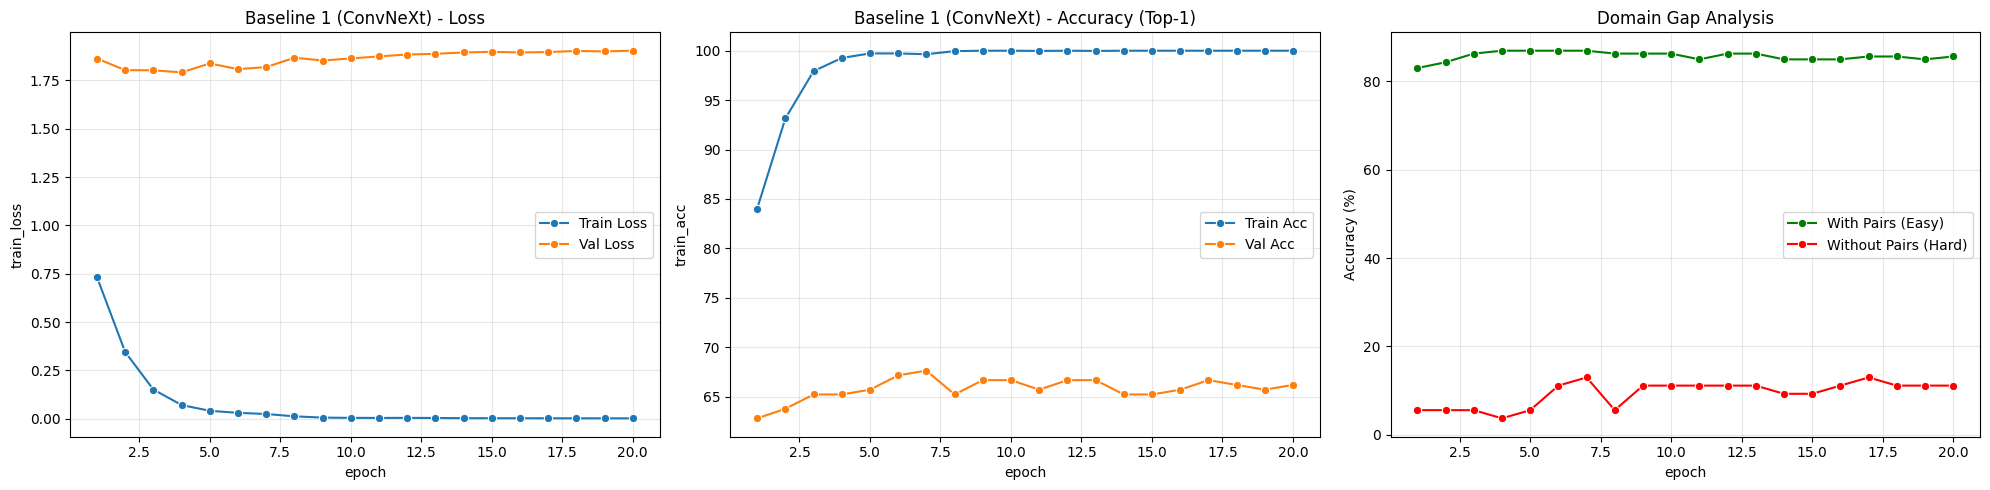

In [ ]:
# --- 📊 Result Analysis ---

# 1. Load Best Model
checkpoint_path = os.path.join(save_dir, "convnext_best.pth")
if os.path.exists(checkpoint_path):
    print(f"📂 Loading best checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path)
    model_cnn.load_state_dict(checkpoint['model_state_dict'])
else:
    print("⚠️ Checkpoint not found, using current model state.")

# 2. Plot Training History
plot_training_results(logger_cnn.get_df(), title="Baseline 1 (ConvNeXt)")

In [ ]:
# 3. Run Full Evaluation Inference
print("\n🔍 Running Final Evaluation on Test Set...")
labels, preds, probs, original_ids = get_predictions(model_cnn, test_loader, device)

# 4. Generate Tables & Metrics
metrics_df = generate_performance_report(labels, preds, probs, original_ids, WITH_PAIRS_IDS, WITHOUT_PAIRS_IDS)
class_stats = analyse_class_performance(labels, preds, original_ids, WITH_PAIRS_IDS)


🔍 Running Final Evaluation on Test Set...


🔍 Inference:   0%|          | 0/7 [00:00<?, ?it/s]


🏆 Key Performance Metrics:
╒═══════════════╤═════════════╤═════════════╤═════════════╤══════════╤════════════╤════════════════╤═════════╕
│ Subset        │   Top-1 Acc │   Top-5 Acc │   Precision │   Recall │   F1-Score │   Balanced Acc │   Count │
╞═══════════════╪═════════════╪═════════════╪═════════════╪══════════╪════════════╪════════════════╪═════════╡
│ Overall       │       67.63 │       77.29 │       57.27 │    67.63 │      59.79 │          57.83 │     207 │
├───────────────┼─────────────┼─────────────┼─────────────┼──────────┼────────────┼────────────────┼─────────┤
│ With-Pairs    │       86.93 │       96.08 │       88.54 │    86.93 │      85.76 │          86.39 │     153 │
├───────────────┼─────────────┼─────────────┼─────────────┼──────────┼────────────┼────────────────┼─────────┤
│ Without-Pairs │       12.96 │       24.07 │       12.04 │    12.96 │      12.35 │          15    │      54 │
╘═══════════════╧═════════════╧═════════════╧═════════════╧══════════╧════════════╧═

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


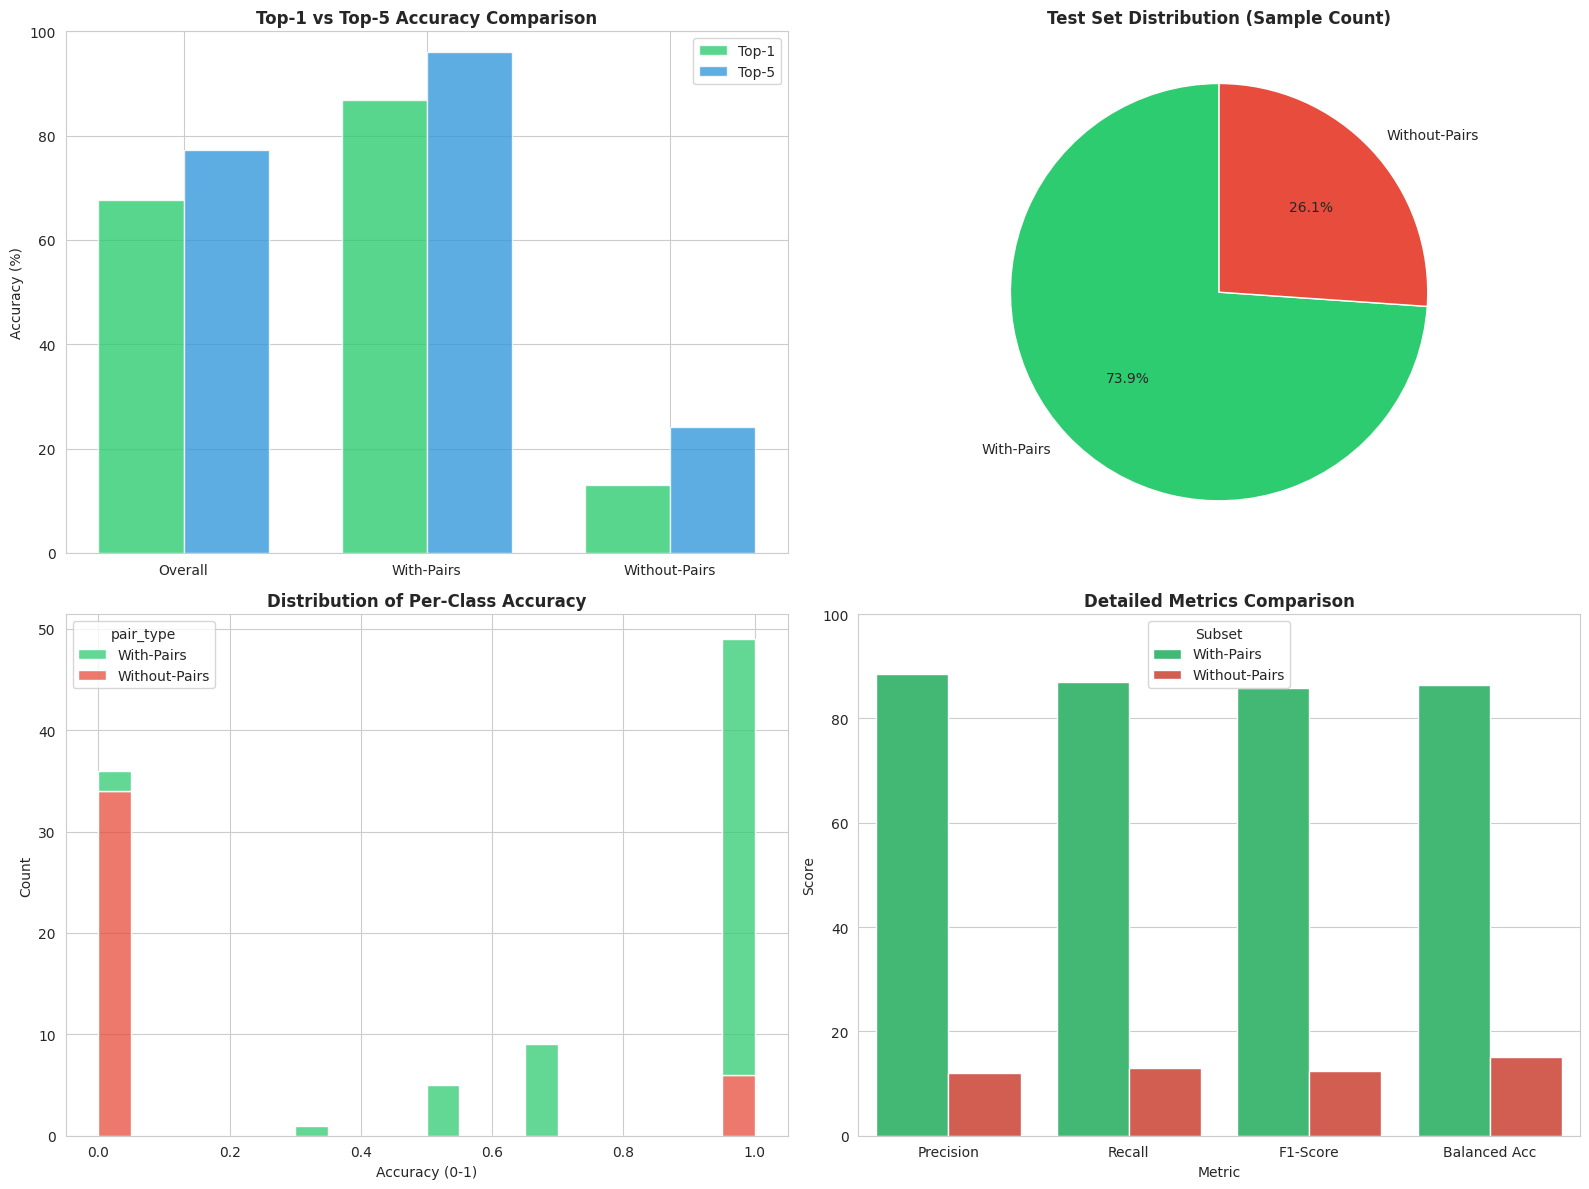

In [ ]:
# 5. Visualisations
visualise_model_performance(metrics_df, class_stats)

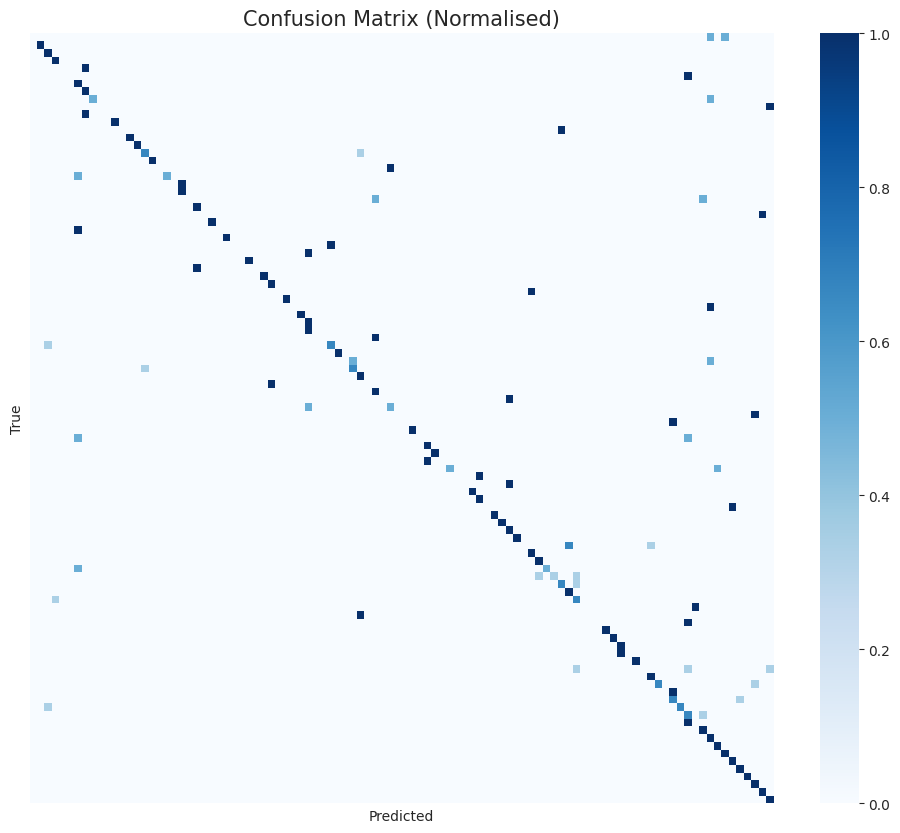

In [ ]:
generate_confusion_matrix(labels, preds)

# 6. Clean Up (Free GPU Memory for Next Section)
del model_cnn, optimiser_cnn, scheduler_cnn
torch.cuda.empty_cache()
print("🧹 GPU Memory Cleared.")

# **5.0 🌿 Baseline 2: DINOv2 + Mix-Stream CNN**

> This fifth section implements the second baseline using the [**Plant-Pretrained DINOv2**](https://www.kaggle.com/models/juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/PyTorch/default) (ViT-B/14), a state-of-the-art vision transformer pretrained on 142 million images. Unlike the CNN baseline, the team employs a **Two-Stage Training Strategy** to preserve the powerful pretrained features while adapting to the specific Herbarium domain.

## &emsp;&emsp;**5.1 Architecture and Data Setup**

> First, the team needs to re-initialise the DataLoaders with **Transformer-specific transforms** (Resize + CenterCrop) instead of the CNN transforms used in Section 4.0. The `get_transforms('vit')` function we defined in Section 2 handles this.

In [ ]:
# --- 🏗️ Architecture & Configuration ---

# 1. Re-initialise DataLoaders for ViT (Standard 224x224 input)
print("🔄 Switching Data Pipeline to Vision Transformer (ViT) mode...")
train_tf_vit, val_tf_vit = get_transforms(model_type='vit', img_size=518)

train_dataset_vit = PlantDataset(train_df, extract_dir, transform=train_tf_vit)
test_dataset_vit = PlantDataset(test_df, extract_dir, transform=val_tf_vit)

train_loader_vit = DataLoader(train_dataset_vit, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
test_loader_vit = DataLoader(test_dataset_vit, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

# 2. Load Plant-Pretrained DINOv2 Backbone
ckpt_path = "/content/drive/MyDrive/ML Project/model_best.pth.tar"
ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
state_dict = ckpt["state_dict"]

# Create the TIMM DINOv2 ViT-B/14 backbone
backbone = timm.create_model(
    "vit_base_patch14_reg4_dinov2.lvd142m",
    pretrained=False,
    num_classes=0  # remove classifier
)

missing, unexpected = backbone.load_state_dict(state_dict, strict=False)
print("✅ Backbone loaded from checkpoint")
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

🔄 Switching Data Pipeline to Vision Transformer (ViT) mode...
✅ Backbone loaded from checkpoint
Missing keys: []
Unexpected keys: ['head.weight', 'head.bias']


In [ ]:
# 3. Define Model Wrapper with Classification Head
class DINOv2PlantModel(nn.Module):
    def __init__(self, backbone, feat_dim, hidden_dim, num_classes):
        super().__init__()
        self.backbone = backbone
        self.mlp = nn.Sequential(
            nn.Linear(feat_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x, return_feat=False):
        # TIMM DINOv2 returns all tokens
        tokens = self.backbone.forward_features(x)
        cls_feat = tokens[:, 0, :]  # CLS token
        logits = self.mlp(cls_feat)

        if return_feat:
            return logits, cls_feat
        return logits

# 4. Instantiate Model
FEATURE_DIM = 768   # ViT-B hidden size
HIDDEN_DIM = 1024   # Classifier hidden size

model_dino = DINOv2PlantModel(backbone, FEATURE_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)
print("✅ Plant-pretrained DINOv2 model ready!")

✅ Plant-pretrained DINOv2 model ready!


## &emsp;&emsp;**5.2 Phase 1 - Train the Head (Linear Probing)**

> In this phase, the team freezes the massive backbone and only train the linear classifier. This aligns the generic DINOv2 features with the specific plant classes without destroying the pretrained weights.

In [ ]:
# --- 🚀 Phase 1: Linear Probing (Head Only) ---

# Hyperparameters for Phase 1
PHASE1_EPOCHS = 3
LR_HEAD = 1e-3

# Optimiser (Only optimising the head)
optimiser_head = optim.AdamW(model_dino.mlp.parameters(), lr=LR_HEAD, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()

print(f"\n🚀 Phase 1: Training Classifier Head ({PHASE1_EPOCHS} Epochs)...")
logger_dino = TrainingLogger()

for epoch in range(1, PHASE1_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{PHASE1_EPOCHS} (Head Only)")

    # Train using utility function
    train_loss, train_acc = train_one_epoch(model_dino, train_loader_vit, optimiser_head, criterion, device, scaler)

    # Evaluate
    val_metrics = evaluate_model(model_dino, test_loader_vit, criterion, device, WITH_PAIRS_IDS, WITHOUT_PAIRS_IDS)

    # Log
    logger_dino.log(epoch, (train_loss, train_acc), val_metrics, LR_HEAD)

    print(f"   Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"   Val Acc:    {val_metrics['val_acc']:.2f}% | With Pairs: {val_metrics['acc_with_pairs']:.2f}%")

print("✅ Phase 1 Complete.")


🚀 Phase 1: Training Classifier Head (3 Epochs)...

Epoch 1/3 (Head Only)


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   Train Loss: 2.3676 | Acc: 47.53%
   Val Acc:    64.73% | With Pairs: 83.66%

Epoch 2/3 (Head Only)


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   Train Loss: 0.8515 | Acc: 77.47%
   Val Acc:    69.57% | With Pairs: 88.89%

Epoch 3/3 (Head Only)


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   Train Loss: 0.5671 | Acc: 84.76%
   Val Acc:    70.05% | With Pairs: 91.50%
✅ Phase 1 Complete.


## &emsp;&emsp;**5.3 Phase 2 - Fine-Tuning (Backbone Adaptation)**

> Now that the head is stable, the team unfreezes the last few blocks of the Transformer to allow the model to adapt its features to the domain shift (Herbarium → Field).

In [ ]:
# --- 🔓 Phase 2: End-to-End Fine-Tuning ---

# Hyperparameters for Phase 2
PHASE2_EPOCHS = 9
LR_FINETUNE = 1e-4 # Smaller learning rate for backbone
UNFREEZE_BLOCKS = 2 # Unfreeze last 2 transformer blocks

# 1. Unfreeze Strategy
def unfreeze_last_blocks(model, n_blocks):
    # Enable grads for the head (already enabled, but ensures safety)
    for param in model.mlp.parameters(): # Corrected from model.head.parameters()
        param.requires_grad = True

    # Unfreeze last n blocks of the backbone
    # DINOv2 blocks are stored in model.blocks
    total_blocks = len(model.backbone.blocks)
    start_idx = total_blocks - n_blocks

    for i, block in enumerate(model.backbone.blocks):
        if i >= start_idx:
            for param in block.parameters():
                param.requires_grad = True

    # Unfreeze Norm layer (crucial for ViT fine-tuning)
    for param in model.backbone.norm.parameters():
        param.requires_grad = True

    print(f"🔓 Unfrozen last {n_blocks} blocks + Norm layer.")

unfreeze_last_blocks(model_dino, UNFREEZE_BLOCKS)

# Re-calculate trainable params
trainable_params = sum(p.numel() for p in model_dino.parameters() if p.requires_grad)
print(f"   New Trainable Parameters: {trainable_params:,}")

# 2. New Optimiser for Phase 2 (captures newly unfrozen params)
optimiser_finetune = optim.AdamW(filter(lambda p: p.requires_grad, model_dino.parameters()),
                                 lr=LR_FINETUNE, weight_decay=1e-4)

# Scheduler
scheduler_dino = optim.lr_scheduler.ReduceLROnPlateau(optimiser_finetune, mode='min', factor=0.5, patience=2)

print(f"\n🚀 Phase 2: Fine-Tuning Backbone ({PHASE2_EPOCHS} Epochs)...")
best_acc = 0.0
save_dir = "/content/drive/MyDrive/ML Project/checkpoints"

for epoch in range(PHASE1_EPOCHS + 1, PHASE1_EPOCHS + PHASE2_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{PHASE1_EPOCHS + PHASE2_EPOCHS} (Fine-Tuning)")

    train_loss, train_acc = train_one_epoch(model_dino, train_loader_vit, optimiser_finetune, criterion, device, scaler)
    val_metrics = evaluate_model(model_dino, test_loader_vit, criterion, device, WITH_PAIRS_IDS, WITHOUT_PAIRS_IDS)

    scheduler_dino.step(val_metrics['val_loss'])
    current_lr = optimiser_finetune.param_groups[0]['lr']

    logger_dino.log(epoch, (train_loss, train_acc), val_metrics, current_lr)

    print(f"   Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"   Val Acc:    {val_metrics['val_acc']:.2f}% | Without Pairs: {val_metrics['acc_without_pairs']:.2f}%")

    if val_metrics['val_acc'] > best_acc:
        best_acc = val_metrics['val_acc']
        save_checkpoint(model_dino, optimiser_finetune, epoch, path=os.path.join(save_dir, "dino_best.pth"))
        print("   🏆 New Best Model Saved!")

print("\n✅ Phase 2 Complete.")

🔓 Unfrozen last 2 blocks + Norm layer.
   New Trainable Parameters: 87,471,972

🚀 Phase 2: Fine-Tuning Backbone (9 Epochs)...

Epoch 4/12 (Fine-Tuning)


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   Train Loss: 0.7760 | Acc: 78.52%
   Val Acc:    68.60% | Without Pairs: 18.52%
   🏆 New Best Model Saved!

Epoch 5/12 (Fine-Tuning)


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   Train Loss: 0.3794 | Acc: 88.41%
   Val Acc:    71.98% | Without Pairs: 22.22%
   🏆 New Best Model Saved!

Epoch 6/12 (Fine-Tuning)


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   Train Loss: 0.1712 | Acc: 94.73%
   Val Acc:    70.53% | Without Pairs: 20.37%

Epoch 7/12 (Fine-Tuning)


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   Train Loss: 0.2609 | Acc: 92.05%
   Val Acc:    69.08% | Without Pairs: 20.37%

Epoch 8/12 (Fine-Tuning)


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   Train Loss: 0.0543 | Acc: 98.50%
   Val Acc:    71.50% | Without Pairs: 16.67%

Epoch 9/12 (Fine-Tuning)


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   Train Loss: 0.0184 | Acc: 99.52%
   Val Acc:    72.95% | Without Pairs: 16.67%
   🏆 New Best Model Saved!

Epoch 10/12 (Fine-Tuning)


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   Train Loss: 0.0098 | Acc: 99.83%
   Val Acc:    71.50% | Without Pairs: 12.96%

Epoch 11/12 (Fine-Tuning)


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   Train Loss: 0.0038 | Acc: 99.98%
   Val Acc:    71.01% | Without Pairs: 12.96%

Epoch 12/12 (Fine-Tuning)


🚀 Training:   0%|          | 0/149 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

   Train Loss: 0.0025 | Acc: 100.00%
   Val Acc:    70.53% | Without Pairs: 11.11%

✅ Phase 2 Complete.


## &emsp;&emsp;**5.4 Result Analysis**

> Now, the team performs a deep-dive evaluation using the standardised reporting tools created in Section 3.0. This ensures the results are directly comparable to future approaches.

📂 Loading best checkpoint from /content/drive/MyDrive/ML Project/checkpoints/dino_best.pth...


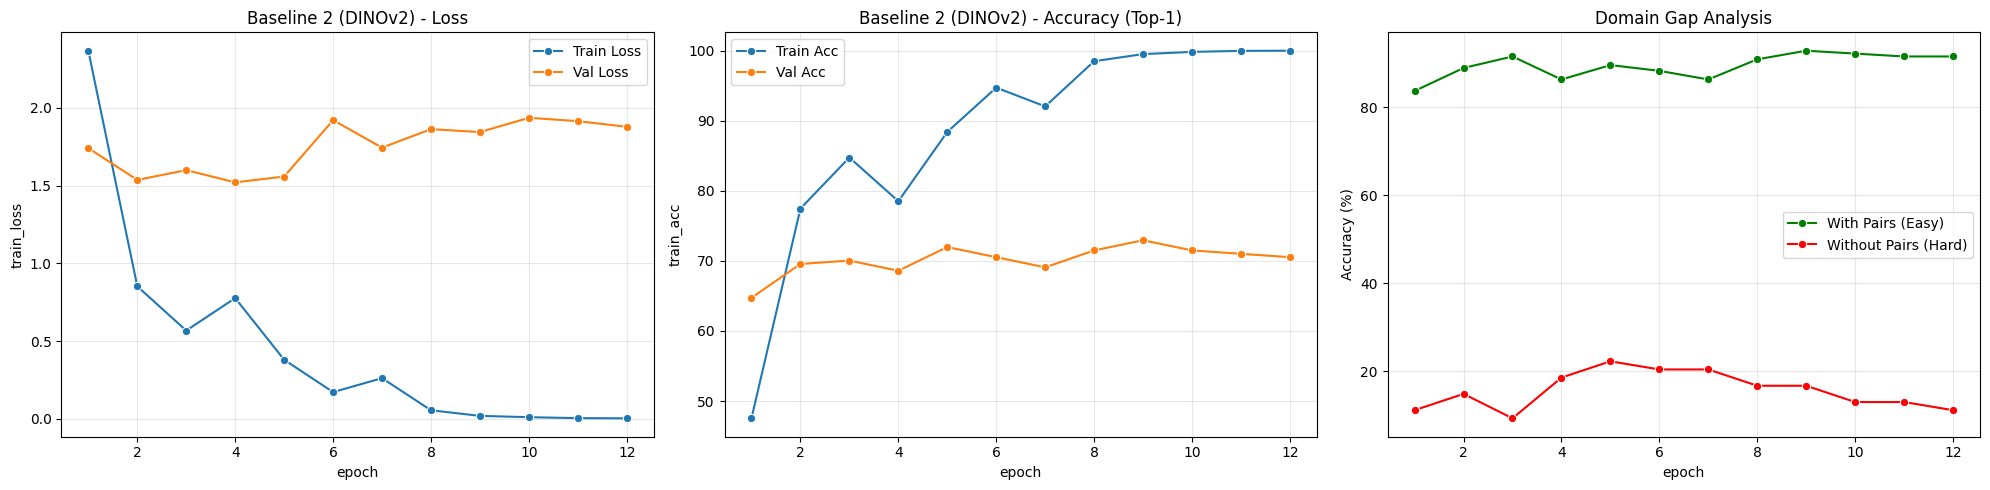

In [ ]:
# --- 📊 Result Analysis ---

# 1. Load Best Model
checkpoint_path = os.path.join(save_dir, "dino_best.pth")
if os.path.exists(checkpoint_path):
    print(f"📂 Loading best checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path)
    model_dino.load_state_dict(checkpoint['model_state_dict'])

# 2. Plot Training History (Combined Phases)
plot_training_results(logger_dino.get_df(), title="Baseline 2 (DINOv2)")

In [ ]:
# 3. Run Full Evaluation
print("\n🔍 Running Final Evaluation on Test Set...")
labels, preds, probs, original_ids = get_predictions(model_dino, test_loader_vit, device)

# 4. Generate Reports
metrics_df = generate_performance_report(labels, preds, probs, original_ids, WITH_PAIRS_IDS, WITHOUT_PAIRS_IDS)
class_stats = analyse_class_performance(labels, preds, original_ids, WITH_PAIRS_IDS)


🔍 Running Final Evaluation on Test Set...


🔍 Inference:   0%|          | 0/7 [00:00<?, ?it/s]


🏆 Key Performance Metrics:
╒═══════════════╤═════════════╤═════════════╤═════════════╤══════════╤════════════╤════════════════╤═════════╕
│ Subset        │   Top-1 Acc │   Top-5 Acc │   Precision │   Recall │   F1-Score │   Balanced Acc │   Count │
╞═══════════════╪═════════════╪═════════════╪═════════════╪══════════╪════════════╪════════════════╪═════════╡
│ Overall       │       72.95 │       81.64 │       63.85 │    72.95 │      66.23 │          63.33 │     207 │
├───────────────┼─────────────┼─────────────┼─────────────┼──────────┼────────────┼────────────────┼─────────┤
│ With-Pairs    │       92.81 │       98.04 │       95.24 │    92.81 │      93.09 │          93.33 │     153 │
├───────────────┼─────────────┼─────────────┼─────────────┼──────────┼────────────┼────────────────┼─────────┤
│ Without-Pairs │       16.67 │       35.19 │       20.37 │    16.67 │      17.59 │          18.33 │      54 │
╘═══════════════╧═════════════╧═════════════╧═════════════╧══════════╧════════════╧═

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


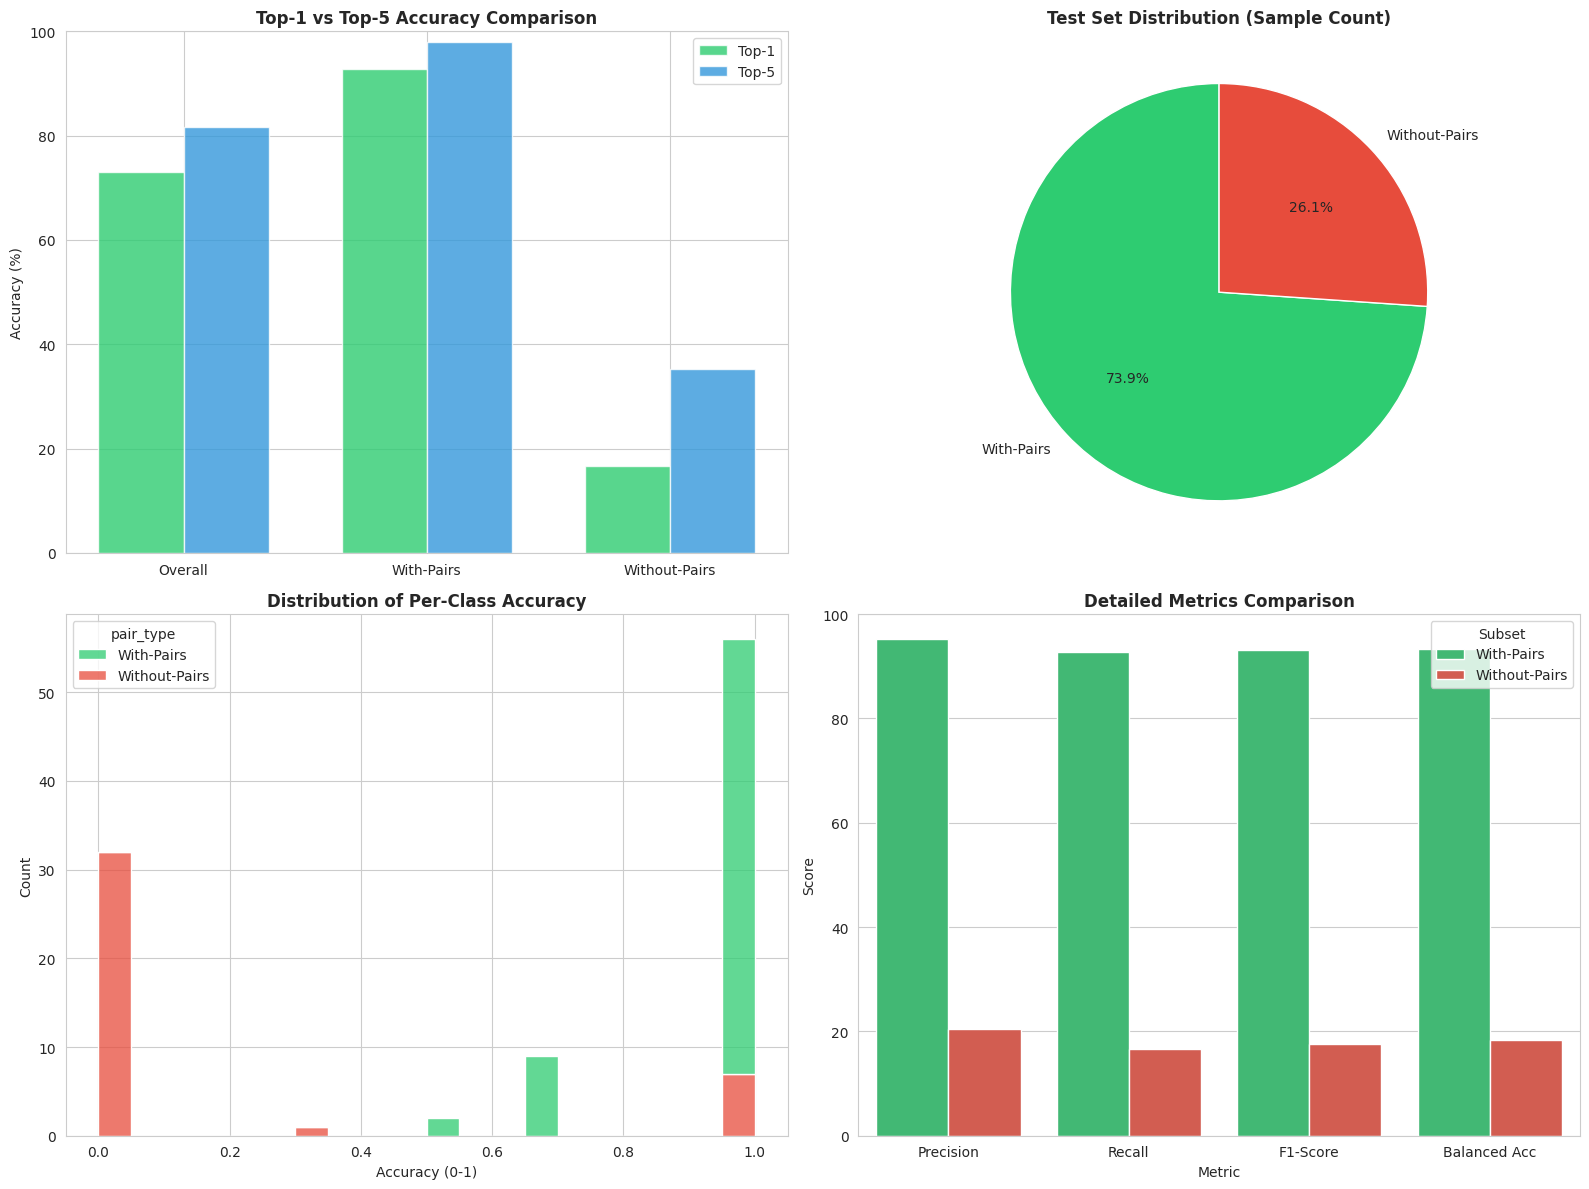

In [ ]:
# 5. Visualisations
visualise_model_performance(metrics_df, class_stats)

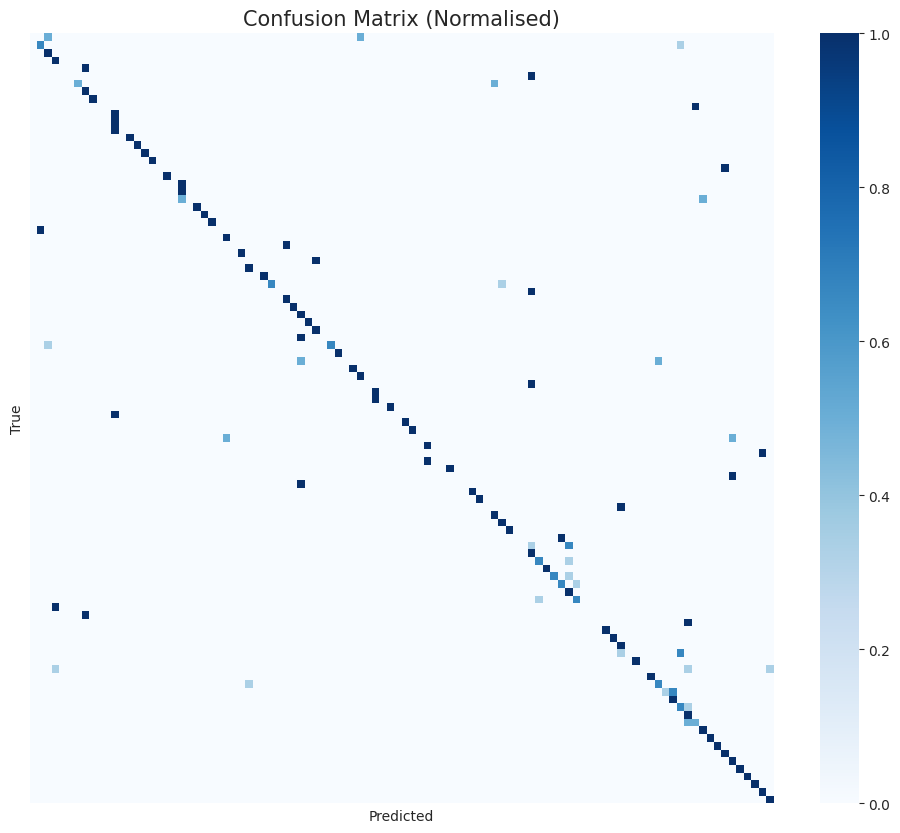

🧹 GPU Memory Cleared.


In [ ]:
generate_confusion_matrix(labels, preds)

# 6. Clean Up
del model_dino, optimiser_head, optimiser_finetune, scheduler_dino
torch.cuda.empty_cache()
print("🧹 GPU Memory Cleared.")

# **6.0 🌲 New Approach: Multi-Task Adversarial Network (DANN + Taxonomy)**

This approach combines three state-of-the-art techniques:

    Domain Adversarial Learning (DANN): Aligns Herbarium and Field domains.
    Taxonomic Multi-Task Learning: Predicts Species, Genus, and Family simultaneously to stabilize learning for rare classes.
    Prototype-Based Inference: Uses herbarium anchors for final classification.

## &emsp;&emsp;**6.1 Data Setup & Taxonomy Mapping**

First, we need to parse your new species_taxonomy.txt file.

In [ ]:
# --- 6.1 🧬 Taxonomy Data Setup ---

def load_taxonomy_data(path):
    """
    Parses species_taxonomy.txt to create Genus and Family mappings.
    Returns mappings from Model Label Index -> Taxon Index.
    """
    if not os.path.exists(path):
        # Fallback if file doesn't exist (create dummy from species list)
        print(f"⚠️ Taxonomy file not found at {path}. Generating from species list...")
        # Assuming species_df exists from Section 2
        tax_df = species_df.copy()
        tax_df['genus'] = tax_df['species_name'].apply(lambda x: x.split()[0])
        tax_df['family'] = "Unknown" # Fallback
    else:
        tax_df = pd.read_csv(path, sep=";")

    # 1. Create Encoders
    genus_le = LabelEncoder()
    family_le = LabelEncoder()

    tax_df['genus_idx'] = genus_le.fit_transform(tax_df['genus'])
    tax_df['family_idx'] = family_le.fit_transform(tax_df['family'])

    # 2. Create Lookup Maps (Species Model Index -> Taxon Index)
    # We need to map the Model's Species Index (0..99) to the correct Genus/Family Index
    # We use the global CLASS_TO_IDX map from Section 2.1

    sp_to_genus = {}
    sp_to_family = {}

    for _, row in tax_df.iterrows():
        bio_id = int(row['class_id'])
        if bio_id in CLASS_TO_IDX:
            model_idx = CLASS_TO_IDX[bio_id]
            sp_to_genus[model_idx] = row['genus_idx']
            sp_to_family[model_idx] = row['family_idx']

    num_genera = len(genus_le.classes_)
    num_families = len(family_le.classes_)

    print(f"🧬 Taxonomy Loaded: {num_genera} Genera, {num_families} Families.")
    return sp_to_genus, sp_to_family, num_genera, num_families

# Create the mappings
SP_TO_GENUS, SP_TO_FAMILY, NUM_GENERA, NUM_FAMILIES = load_taxonomy_data("/content/drive/MyDrive/ML Project/species_taxonomy.txt")

🧬 Taxonomy Loaded: 75 Genera, 37 Families.


## &emsp;&emsp;**6.2 Unified Architecture (DANN + Multi-Task + DINOv2)**

> The team needs a specific custom module here. The team will also introduce a Gradient Reversal Layer (GRL) which is the magic component that allows the model to "unlearn" domain-specific features (like the paper background of herbarium sheets).

In [ ]:
class GradientReversal(Function):
    """
    Gradient Reversal Layer (GRL).
    Forward: Identity.
    Backward: Negates gradients to confuse the discriminator.
    """
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

def grad_reverse(x, alpha=1.0):
    return GradientReversal.apply(x, alpha)

class PlantMultiTaskDANN(nn.Module):
    def __init__(self, num_classes, num_genera, num_families, backbone_name="vit_base_patch14_reg4_dinov2.lvd142m"):
        super().__init__()

        # 1. Backbone (DINOv2 Plant Pretrained)
        # num_classes=0 ensures we get features, but we use forward_features anyway
        self.backbone = timm.create_model(backbone_name, pretrained=False, num_classes=0)
        self.embed_dim = 768 # ViT-B Hidden Dimension

        # 2. Main Task: Species Classifier (100 classes)
        self.classifier_species = nn.Linear(self.embed_dim, num_classes)

        # 3. Auxiliary Tasks: Taxonomy
        self.classifier_genus = nn.Linear(self.embed_dim, num_genera)
        self.classifier_family = nn.Linear(self.embed_dim, num_families)

        # 4. Adversarial Task: Domain Discriminator (DANN)
        # Tries to distinguish Herbarium (0) vs Field (1)
        self.domain_discriminator = nn.Sequential(
            nn.Linear(self.embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x, alpha=1.0):
        # 1. Extract Feature Tokens
        tokens = self.backbone.forward_features(x)

        # 2. Select CLS Token (Index 0)
        # Shape: (Batch, 768)
        feats = tokens[:, 0, :]

        # 3. Main Tasks (Species, Genus, Family)
        logits_sp = self.classifier_species(feats)
        logits_gen = self.classifier_genus(feats)
        logits_fam = self.classifier_family(feats)

        # 4. Adversarial Task (Domain)
        # Reverse gradients so backbone learns to HIDE domain info
        reverse_feats = grad_reverse(feats, alpha)
        logits_dom = self.domain_discriminator(reverse_feats)

        return logits_sp, logits_dom, logits_gen, logits_fam, feats

# Initialize & Load Weights
model_final = PlantMultiTaskDANN(NUM_CLASSES, NUM_GENERA, NUM_FAMILIES).to(device)

ckpt_path = "/content/drive/MyDrive/ML Project/model_best.pth.tar"
if os.path.exists(ckpt_path):
    print("📂 Loading Plant-Pretrained weights...")
    ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
    state = ckpt["state_dict"] if "state_dict" in ckpt else ckpt

    # Load backbone weights (strict=False ignores missing classifier heads)
    model_final.backbone.load_state_dict(state, strict=False)
    print("✅ Weights Loaded.")
else:
    print("⚠️ Pretrained weights not found! Initializing random DINOv2 backbone.")

📂 Loading Plant-Pretrained weights...
✅ Weights Loaded.


In [ ]:
 # Re-initialise DataLoaders for ViT (Standard 224x224 input)

print("🔄 Switching Data Pipeline to Vision Transformer (ViT) mode...")
train_tf_vit, val_tf_vit = get_transforms(model_type='vit', img_size=518)

train_dataset_vit = PlantDataset(train_df, extract_dir, transform=train_tf_vit)
test_dataset_vit = PlantDataset(test_df, extract_dir, transform=val_tf_vit)

train_loader_vit = DataLoader(train_dataset_vit, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
test_loader_vit = DataLoader(test_dataset_vit, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

🔄 Switching Data Pipeline to Vision Transformer (ViT) mode...


## &emsp;&emsp;**6.3 Unified Training Loop**

> The team would need a custom training loop because there are now two losses to consider: <br>1. Classification Loss: Predict the correct species. <br>2. Domain Loss: The discriminator tries to guess the domain, but the backbone tries to fail at this (via the Gradient Reversal). <br> The team also needs to handle the data properly. Therefore, the team will use the **Unified DataLoaders** from Section 2, but the team needs to ensure the batch contains `domain` labels. Fortunately, the `PlantDataset` already returns `domain` (0 for Herbarium, 1 for Photo)!

In [ ]:
# --- 6.3 🏋️ Unified Training Loop ---

def train_epoch_multitask_dann(model, loader, optimizer, device, alpha, sp_to_genus, sp_to_family):
    model.train()
    metrics = defaultdict(float)
    count = 0

    crit = nn.CrossEntropyLoss()

    # Create tensor lookups for taxonomy
    genus_lookup = torch.tensor([sp_to_genus[i] for i in range(len(sp_to_genus))], device=device)
    family_lookup = torch.tensor([sp_to_family[i] for i in range(len(sp_to_family))], device=device)

    pbar = tqdm(loader, desc=f"⚔️ Multi-Task DANN (α={alpha:.2f})", leave=False)

    for batch in pbar:
        # Unpack 4 items from PlantDataset
        images, labels, domains = batch[0].to(device), batch[1].to(device), batch[2].to(device)

        # Derive Taxonomy Labels from Species Labels
        genus_labels = genus_lookup[labels]
        family_labels = family_lookup[labels]

        optimizer.zero_grad()

        # Forward
        out_sp, out_dom, out_gen, out_fam, _ = model(images, alpha)

        # Calculate Losses
        loss_sp = crit(out_sp, labels)
        loss_dom = crit(out_dom, domains)
        loss_gen = crit(out_gen, genus_labels)
        loss_fam = crit(out_fam, family_labels)

        # Weighted Sum
        # Species = 1.0 (Main)
        # Domain = 1.0 (Adversarial)
        # Genus/Family = 0.5 (Support)
        total_loss = loss_sp + loss_dom + 0.5 * (loss_gen + loss_fam)

        total_loss.backward()
        optimizer.step()

        # Track metrics
        metrics['loss'] += total_loss.item()
        metrics['acc_sp'] += (out_sp.argmax(1) == labels).float().mean().item()
        count += 1

        pbar.set_postfix({"L": f"{total_loss.item():.2f}", "Acc": f"{metrics['acc_sp']/count:.1%}"})

    return {k: v/count for k, v in metrics.items()}

In [ ]:
# --- Execute Training ---
EPOCHS = 20
LR = 5e-5
optimizer = optim.AdamW(model_final.parameters(), lr=LR)
logger = TrainingLogger()

# Re-init DataLoaders (ViT Transforms)
train_loader = DataLoader(train_dataset_vit, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset_vit, batch_size=16, shuffle=False, num_workers=0)

# Setup Saving
SAVE_DIR = "/content/drive/MyDrive/ML Project/checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)
best_val_acc = 0.0
best_model_path = os.path.join(SAVE_DIR, "multitask_dann_best.pth")

print(f"🚀 Starting Unified Training ({EPOCHS} Epochs)...")

for epoch in range(1, EPOCHS + 1):
    alpha = 2.0 / (1.0 + np.exp(-10 * (epoch / EPOCHS))) - 1.0 # Gradual DANN

    train_stats = train_epoch_multitask_dann(model_final, train_loader, optimizer, device, alpha, SP_TO_GENUS, SP_TO_FAMILY)

    # Eval (Use our robust Section 3 function)
    val_metrics = evaluate_model(model_final, test_loader, nn.CrossEntropyLoss(), device, WITH_PAIRS_IDS, WITHOUT_PAIRS_IDS)

    # Log
    logger.log(epoch, (train_stats['loss'], train_stats['acc_sp']), val_metrics, LR)

    print(f"Ep {epoch} | Train: {train_stats['acc_sp']:.1%} | Val: {val_metrics['val_acc']:.1f}% | "
          f"Without-Pairs: {val_metrics['acc_without_pairs']:.1f}%")

    # --- 💾 SAVE BEST MODEL ---
    # We save based on Overall Validation Accuracy
    if val_metrics['val_acc'] > best_val_acc:
        best_val_acc = val_metrics['val_acc']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_final.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_val_acc,
        }, best_model_path)
        print(f"   💾 New Best Model Saved to Drive! ({best_val_acc:.2f}%)")

🚀 Starting Unified Training (20 Epochs)...


⚔️ Multi-Task DANN (α=0.24):   0%|          | 0/406 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Ep 1 | Train: 57.3% | Val: 63.3% | Without-Pairs: 20.4%
   💾 New Best Model Saved to Drive! (63.29%)


⚔️ Multi-Task DANN (α=0.46):   0%|          | 0/406 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Ep 2 | Train: 84.8% | Val: 70.5% | Without-Pairs: 18.5%
   💾 New Best Model Saved to Drive! (70.53%)


⚔️ Multi-Task DANN (α=0.64):   0%|          | 0/406 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Ep 3 | Train: 93.2% | Val: 71.5% | Without-Pairs: 25.9%
   💾 New Best Model Saved to Drive! (71.50%)


⚔️ Multi-Task DANN (α=0.76):   0%|          | 0/406 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Ep 4 | Train: 96.8% | Val: 73.4% | Without-Pairs: 22.2%
   💾 New Best Model Saved to Drive! (73.43%)


⚔️ Multi-Task DANN (α=0.85):   0%|          | 0/406 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Ep 5 | Train: 97.8% | Val: 73.4% | Without-Pairs: 24.1%


⚔️ Multi-Task DANN (α=0.91):   0%|          | 0/406 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Ep 6 | Train: 98.6% | Val: 70.5% | Without-Pairs: 18.5%


⚔️ Multi-Task DANN (α=0.94):   0%|          | 0/406 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Ep 7 | Train: 97.7% | Val: 69.1% | Without-Pairs: 16.7%


⚔️ Multi-Task DANN (α=0.96):   0%|          | 0/406 [00:00<?, ?it/s]

🔍 Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Ep 8 | Train: 96.0% | Val: 68.6% | Without-Pairs: 9.3%


⚔️ Multi-Task DANN (α=0.98):   0%|          | 0/406 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def plot_training_results(df, title="Model Performance"):
    """
    Plots three key dynamics:
    1. Loss (Train vs Val)
    2. Overall Accuracy (Train vs Val)
    3. The Domain Gap (With-Pairs vs Without-Pairs Accuracy)
    """
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # 1. Loss Curve
    if 'train_loss' in df.columns and 'val_loss' in df.columns:
        sns.lineplot(data=df, x="epoch", y="train_loss", label="Train Loss", ax=axes[0], marker='o', color='tab:blue')
        sns.lineplot(data=df, x="epoch", y="val_loss", label="Val Loss", ax=axes[0], marker='o', color='tab:red')
        axes[0].set_title(f"{title} - Loss Trend", fontweight='bold')
        axes[0].set_ylabel("Loss")
        axes[0].set_xlabel("Epoch")
        axes[0].legend()

    # 2. Overall Accuracy Curve
    if 'train_acc' in df.columns and 'val_acc' in df.columns:
        sns.lineplot(data=df, x="epoch", y="train_acc", label="Train Acc", ax=axes[1], marker='o', color='tab:blue')
        sns.lineplot(data=df, x="epoch", y="val_acc", label="Val Acc", ax=axes[1], marker='o', color='tab:red')
        axes[1].set_title(f"{title} - Top-1 Accuracy", fontweight='bold')
        axes[1].set_ylabel("Accuracy (%)")
        axes[1].set_xlabel("Epoch")
        axes[1].legend()

    # 3. Domain Gap Analysis (Crucial for this project)
    # This shows if the model is actually generalizing to unseen field species
    if 'acc_with_pairs' in df.columns and 'acc_without_pairs' in df.columns:
        sns.lineplot(data=df, x="epoch", y="acc_with_pairs", label="With Pairs (Seen Domain)", ax=axes[2], marker='s', color='green')
        sns.lineplot(data=df, x="epoch", y="acc_without_pairs", label="Without Pairs (Unseen Domain)", ax=axes[2], marker='^', color='orange')
        axes[2].set_title("Domain Gap Analysis (Generalization)", fontweight='bold')
        axes[2].set_ylabel("Accuracy (%)")
        axes[2].set_xlabel("Epoch")
        axes[2].legend()

        # Annotate the final gap
        final_with = df['acc_with_pairs'].iloc[-1]
        final_without = df['acc_without_pairs'].iloc[-1]
        gap = final_with - final_without
        axes[2].text(0.5, 0.5, f"Gap: {gap:.1f}%", transform=axes[2].transAxes,
                     ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

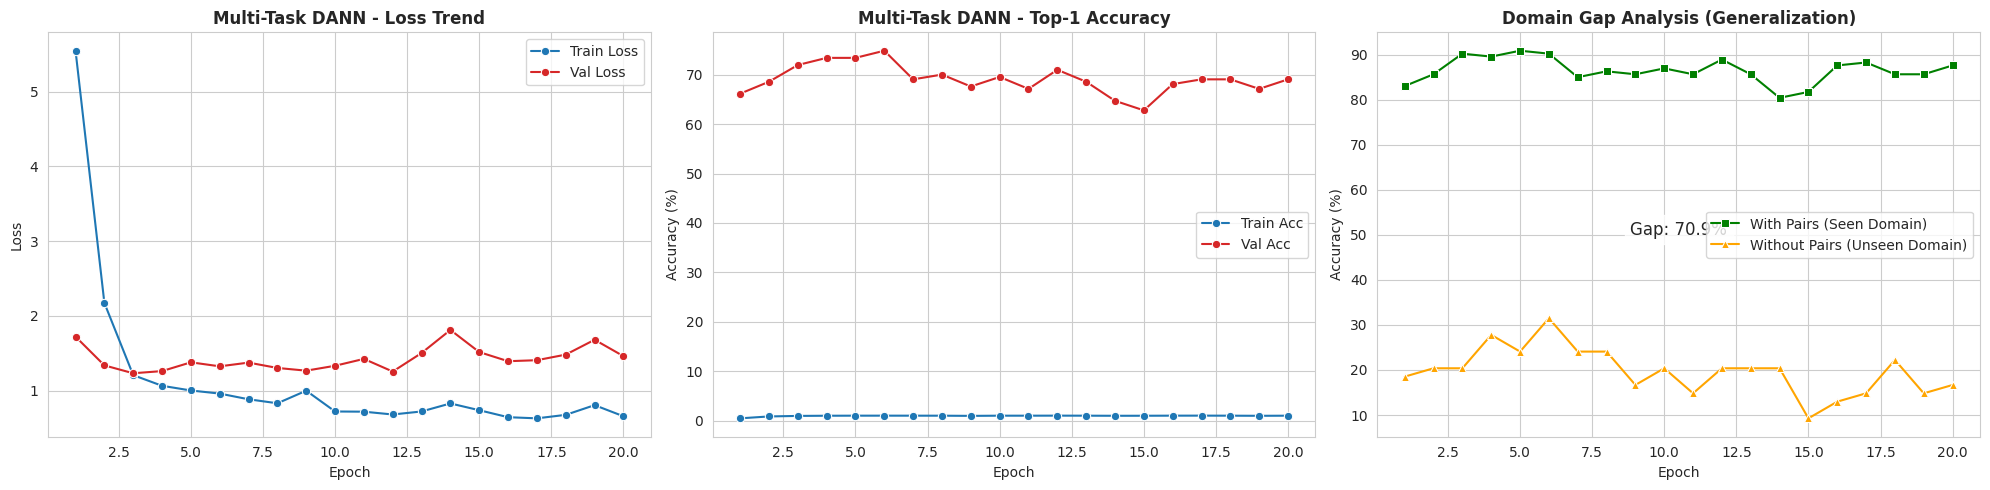

In [ ]:
# Visualize
plot_training_results(logger.get_df(), title="Multi-Task DANN")

## &emsp;&emsp;**6.4 Final Inference (Prototype + TTA)**

> Here the team then applies the Prototype Refinement for the final inference. This combines the DANN training with the Metric Learning idea from the team's earlier trials and errors, but applies it to ALL classes.

In [ ]:
# --- 6.4 📈 Final Inference (Prototype + TTA) ---

# 1. Build Herbarium Prototypes
def get_prototypes(model, loader, device):
    model.eval()
    prototypes = torch.zeros(NUM_CLASSES, 768).to(device)
    counts = torch.zeros(NUM_CLASSES).to(device)

    print("🧪 Building Herbarium Prototypes...")
    with torch.no_grad():
        for batch in tqdm(loader, leave=False):
            imgs, labels, domains = batch[0].to(device), batch[1].to(device), batch[2].to(device)

            # Filter for Herbarium (0)
            mask = (domains == 0)
            if mask.sum() == 0: continue

            # Get features (index 4 of return tuple is feats)
            _, _, _, _, feats = model(imgs[mask], alpha=0.0)
            feats = F.normalize(feats, p=2, dim=1)

            for i, lbl in enumerate(labels[mask]):
                prototypes[lbl] += feats[i]
                counts[lbl] += 1

    # Average
    for i in range(NUM_CLASSES):
        if counts[i] > 0:
            prototypes[i] /= counts[i]
        prototypes[i] = F.normalize(prototypes[i], p=2, dim=0)
    return prototypes

# Load the best epoch before running the final Prototype Inference
print("\n↺ Loading Best Checkpoint for Final Inference...")
checkpoint = torch.load(best_model_path)
model_final.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded Epoch {checkpoint['epoch']} with Acc: {checkpoint['best_acc']:.2f}%")

# --- Execute Prototype Build & Save ---
PROTO_PATH = os.path.join(SAVE_DIR, "prototypes.pth")

# Check if we already computed them (useful if restarting notebook)
if os.path.exists(PROTO_PATH):
    print(f"📂 Loading existing prototypes from {PROTO_PATH}...")
    prototypes = torch.load(PROTO_PATH, map_location=device)
else:
    # Calculate fresh
    prototypes = get_prototypes(model_final, train_loader, device)
    # Save them!
    torch.save(prototypes, PROTO_PATH)
    print(f"💾 Prototypes saved to {PROTO_PATH}")


↺ Loading Best Checkpoint for Final Inference...
✅ Loaded Epoch 6 with Acc: 74.88%
🧪 Building Herbarium Prototypes...


  0%|          | 0/297 [00:00<?, ?it/s]

💾 Prototypes saved to /content/drive/MyDrive/ML Project/checkpoints/prototypes.pth


In [ ]:
# 2. TTA Inference Function
def get_tta_transforms(img_size=518):
    norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return [
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(img_size), transforms.ToTensor(), norm]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(img_size), transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor(), norm]),
    ]

print(f"🔍 Running Final Inference with TTA...")
tta_transforms = get_tta_transforms(518)
final_preds, final_labels, final_probs, final_ids = [], [], [], []

# Iterate dataset directly for TTA
for i in tqdm(range(len(test_dataset_vit))):
    row = test_dataset_vit.df.iloc[i]
    path = os.path.join(test_dataset_vit.root_dir, row['image_path'])
    try:
        img_pil = Image.open(path).convert("RGB")
    except: continue

    # Create Batch of Augmentations
    aug_imgs = torch.stack([t(img_pil) for t in tta_transforms]).to(device)

    with torch.no_grad():
        # Forward pass (get feats)
        _, _, _, _, feats = model_final(aug_imgs, alpha=0.0)
        feats = F.normalize(feats, p=2, dim=1)

        # Mean Embedding
        avg_feat = feats.mean(dim=0, keepdim=True)
        avg_feat = F.normalize(avg_feat, p=2, dim=1)

        # Similarity
        sims = torch.mm(avg_feat, prototypes.t())
        pred = sims.argmax(dim=1).item()

    final_preds.append(pred)
    final_labels.append(row['label_idx'])
    final_probs.append(sims.cpu().numpy())
    final_ids.append(row['class_id'])

# 3. Final Report
metrics_final = generate_performance_report(
    np.array(final_labels), np.array(final_preds), np.array(final_probs).squeeze(),
    np.array(final_ids), WITH_PAIRS_IDS, WITHOUT_PAIRS_IDS
)

🔍 Running Final Inference with TTA...


  0%|          | 0/207 [00:00<?, ?it/s]


🏆 Key Performance Metrics:
╒═══════════════╤═════════════╤═════════════╤═════════════╤══════════╤════════════╤════════════════╤═════════╕
│ Subset        │   Top-1 Acc │   Top-5 Acc │   Precision │   Recall │   F1-Score │   Balanced Acc │   Count │
╞═══════════════╪═════════════╪═════════════╪═════════════╪══════════╪════════════╪════════════════╪═════════╡
│ Overall       │       74.88 │       85.99 │       71.48 │    74.88 │      70.23 │          65.17 │     207 │
├───────────────┼─────────────┼─────────────┼─────────────┼──────────┼────────────┼────────────────┼─────────┤
│ With-Pairs    │       90.2  │       95.42 │       93.39 │    90.2  │      90.07 │          90    │     153 │
├───────────────┼─────────────┼─────────────┼─────────────┼──────────┼────────────┼────────────────┼─────────┤
│ Without-Pairs │       31.48 │       59.26 │       36.73 │    31.48 │      31.17 │          27.92 │      54 │
╘═══════════════╧═════════════╧═════════════╧═════════════╧══════════╧════════════╧═

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [ ]:
class_stats = analyse_class_performance(np.array(final_labels), np.array(final_preds), np.array(final_ids), WITH_PAIRS_IDS)


🌟 Top 10 Best Performing Classes:
  original_id    accuracy    count  pair_type
-------------  ----------  -------  -------------
        12254           1        2  Without-Pairs
        12910           1        3  With-Pairs
        13330           1        2  With-Pairs
        13370           1        3  With-Pairs
       126895           1        1  Without-Pairs
       130657           1        1  Without-Pairs
        15318           1        2  With-Pairs
        14353           1        2  With-Pairs
        29686           1        3  With-Pairs
        19489           1        3  With-Pairs

⚠️ Top 10 Worst Performing Classes:
  original_id    accuracy    count  pair_type
-------------  ----------  -------  -------------
       141332           0        1  Without-Pairs
       141336           0        1  Without-Pairs
       140367           0        2  Without-Pairs
       136761           0        1  Without-Pairs
       142736           0        2  Without-Pairs
       

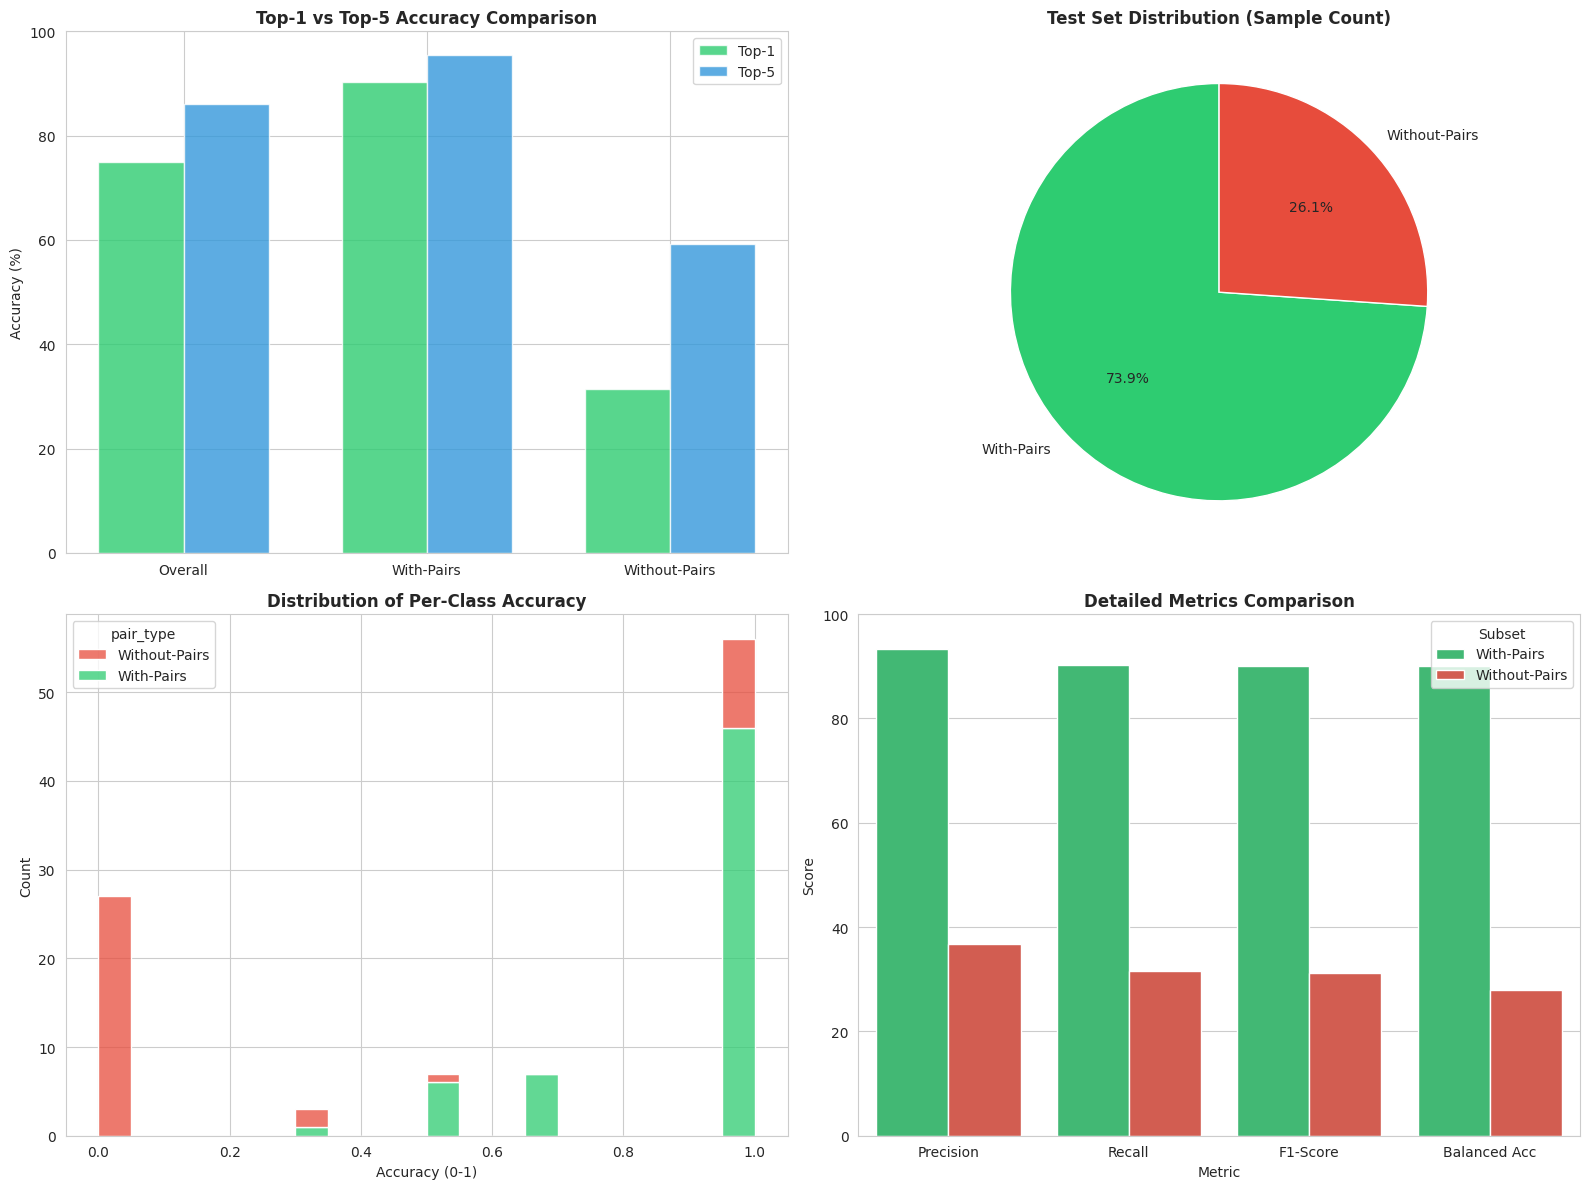

In [ ]:
visualise_model_performance(metrics_final, class_stats)

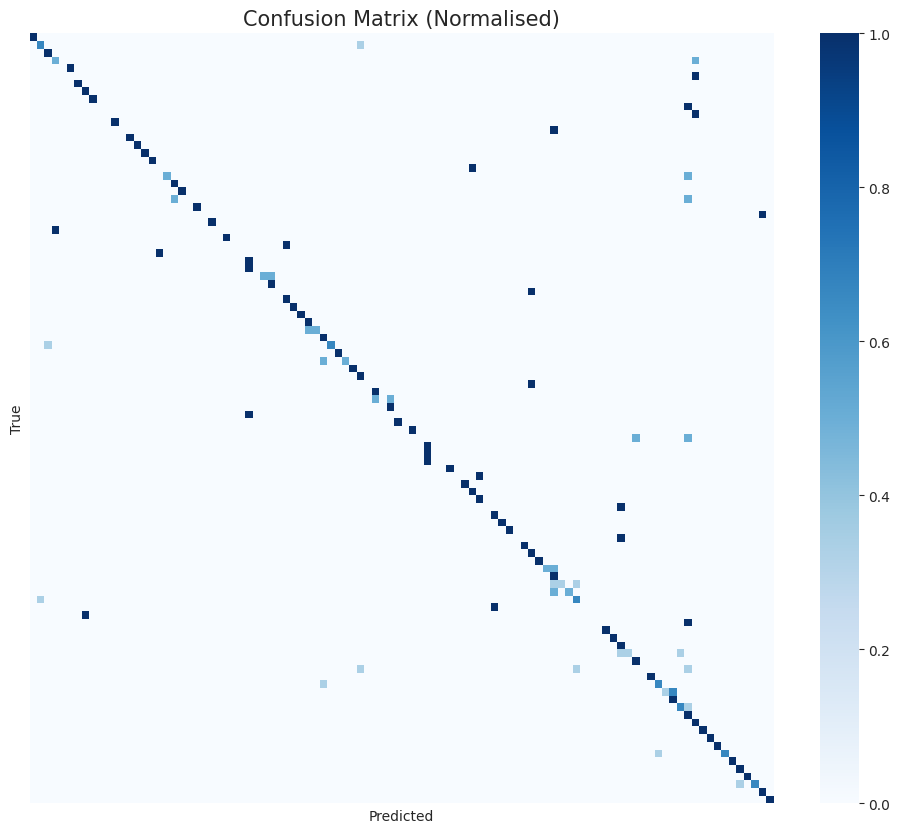

In [ ]:
generate_confusion_matrix(np.array(final_labels), np.array(final_preds))

# **7.0 🌲 New Approach: Metric+Hybrid Ensemble**

In [ ]:
# =========================
# Pass configurations
# =========================
PROJECT_ROOT = Path.cwd().parents[1]

DATASET_DIRNAME = "content/data"
DATA_ROOT = PROJECT_ROOT / DATASET_DIRNAME

TRAIN_DIR = DATA_ROOT / "train"
TEST_DIR = DATA_ROOT / "test"

LIST_DIR = DATA_ROOT / "list"
TRAIN_LIST = LIST_DIR / "train.txt"
TEST_LIST = LIST_DIR / "test.txt"
SPECIES_LIST = LIST_DIR / "species_list.txt"
GROUNDTRUTH = LIST_DIR / "groundtruth.txt"
CLASS_WITH_PAIRS = LIST_DIR / "class_with_pairs.txt"
CLASS_WITHOUT_PAIRS = LIST_DIR / "class_without_pairs.txt"

NUM_CLASSES = 100

IMAGE_SIZE = 518
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

# =========================
# Device Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Root: {DATA_ROOT}")


# =========================
# Constant Configuration
# =========================
HERBARIUM_DOMAIN = 0  # 0 = herbarium, 1 = photo
PHOTO_DOMAIN = 1
EMBED_DIM = 512
NUM_WORKERS = 0
EPOCHS = 30
BATCH_SIZE = 8
USE_AMP = (device.type == "cuda")

LR_BACKBONE_MAX = 1e-6  # Topmost backbone layers
LAYER_DECAY = 0.8       # Each layer gets 80% of the LR of the layer above it
LR_BACKBONE = 1e-6      # smaller LR for pretrained DINO
LR_HEAD = 1e-6          # larger LR for randomly init projection head
WEIGHT_DECAY = 1e-4
TRIPLET_BATCH_SIZE = 4
TRIPLET_NUM_WORKERS = 0

Device: cuda
Project Root: /
Data Root: /content/data


In [ ]:
# =========================
# 2. Data Preprocessing
# =========================

# --- Transforms ---

def build_train_transform(image_size: int = IMAGE_SIZE):
    return transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(
            brightness=0.4,
            contrast=0.4,
            saturation=0.2,
            hue=0.1,
        ),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

def build_eval_transform(image_size: int = IMAGE_SIZE):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

# --- Data Utilities ---

_LABEL_MAP = None

def _get_label_map():
    global _LABEL_MAP
    if _LABEL_MAP is not None:
        return _LABEL_MAP

    mapping = {}
    idx = 0
    if not SPECIES_LIST.exists():
        print(f"Warning: {SPECIES_LIST} not found.")
        return {}

    with SPECIES_LIST.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            left = line.split(";", 1)[0].strip()
            try:
                raw_id = int(left)
            except ValueError:
                continue

            if raw_id not in mapping:
                mapping[raw_id] = idx
                idx += 1

    _LABEL_MAP = mapping
    return mapping

def _map_label(raw_label: int) -> int:
    mapping = _get_label_map()
    if raw_label not in mapping:
        # Fallback or error based on preference
        raise KeyError(f"Raw label {raw_label} not found in species_list.txt")
    return mapping[raw_label]

def _load_raw_id_list(path: Path):
    ids = []
    if not path.exists():
        return ids
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            token = line.split(";", 1)[0].split()[0]
            try:
                raw_id = int(token)
            except ValueError:
                continue
            ids.append(raw_id)
    return ids

def get_with_without_label_sets():
    mapping = _get_label_map()
    with_ids = _load_raw_id_list(CLASS_WITH_PAIRS)
    without_ids = _load_raw_id_list(CLASS_WITHOUT_PAIRS)

    with_set = {mapping[i] for i in with_ids if i in mapping}
    without_set = {mapping[i] for i in without_ids if i in mapping}
    return with_set, without_set

def _parse_train_list(path: Path, root: Path) -> List[Dict]:
    samples: List[Dict] = []
    if not path.exists():
        print(f"Error: Train list {path} not found.")
        return samples

    with path.open("r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rel_path, label_str = line.split()
            label = _map_label(int(label_str))
            full_path = root / rel_path

            if "herbarium" in rel_path:
                domain = 0
            elif "photo" in rel_path:
                domain = 1
            else:
                # fallback
                domain = 0

            samples.append({
                "path": full_path,
                "label": label,
                "domain": domain,
                "rel_path": rel_path,
            })
    return samples

def _parse_test_list_with_groundtruth(test_list_path: Path, gt_path: Path, dataset_root: Path) -> List[Dict]:
    rel_paths: List[str] = []
    if not test_list_path.exists() or not gt_path.exists():
        print("Error: Test list or Groundtruth not found.")
        return []

    with test_list_path.open("r") as f:
        for line in f:
            rel_path = line.strip()
            if not rel_path:
                continue
            rel_paths.append(rel_path)

    gt_entries: List[Tuple[str, int]] = []
    with gt_path.open("r") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) == 1:
                gt_entries.append(("", _map_label(int(parts[0]))))
            else:
                rel_from_gt = parts[0]
                label = _map_label(int(parts[-1]))
                gt_entries.append((rel_from_gt, label))

    if len(rel_paths) != len(gt_entries):
        raise ValueError(f"Mismatch length: {len(rel_paths)} vs {len(gt_entries)}")

    samples: List[Dict] = []
    for idx, rel_path in enumerate(rel_paths):
        rel_from_gt, label = gt_entries[idx]
        if rel_from_gt and rel_from_gt != rel_path:
            raise ValueError(f"Mismatch at line {idx + 1}: '{rel_from_gt}' vs '{rel_path}'")

        full_path = dataset_root / rel_path
        samples.append({
            "path": full_path,
            "label": label,
            "domain": 1,
            "rel_path": rel_path,
        })

    return samples

class HerbFieldDataset(Dataset):
    def __init__(self, samples: List[Dict], transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int):
        s = self.samples[idx]
        try:
            img = Image.open(s["path"]).convert("RGB")
        except Exception as e:
            print(f"Error loading {s['path']}: {e}")
            # Create blank image on failure to prevent crash
            img = Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE))

        if self.transform is not None:
            img = self.transform(img)
        return {
            "image": img,
            "label": s["label"],
            "domain": s["domain"],
            "rel_path": s["rel_path"],
        }

def compute_class_weights(samples: List[Dict]) -> torch.Tensor:
    counts = torch.zeros(NUM_CLASSES, dtype=torch.float)
    for s in samples:
        counts[s["label"]] += 1.0
    counts = torch.clamp(counts, min=1.0)
    weights = 1.0 / torch.log1p(counts)
    return weights

def build_train_dataset() -> HerbFieldDataset:
    samples = _parse_train_list(TRAIN_LIST, DATA_ROOT)
    return HerbFieldDataset(samples, transform=build_train_transform())

def build_test_dataset() -> HerbFieldDataset:
    samples = _parse_test_list_with_groundtruth(TEST_LIST, GROUNDTRUTH, DATA_ROOT)
    return HerbFieldDataset(samples, transform=build_eval_transform())

# --- Initialization ---

print("Initializing datasets...")
train_ds = build_train_dataset()
test_ds = build_test_dataset()
with_set, without_set = get_with_without_label_sets()

print(f"Train size: {len(train_ds)}")
print(f"Test size: {len(test_ds)}")
print(f"With-Pairs classes: {len(with_set)}")
print(f"Without-Pairs classes: {len(without_set)}")
all_train_labels = {s["label"] for s in train_ds.samples}
all_test_labels = {s["label"] for s in test_ds.samples}

print("Distinct train labels:", len(all_train_labels))
print("Distinct test labels :", len(all_test_labels))

Initializing datasets...
Train size: 4744
Test size: 207
With-Pairs classes: 60
Without-Pairs classes: 40
Distinct train labels: 100
Distinct test labels : 100


In [ ]:
# =========================
# 3. Data Loaders & Triplet Dataset
# =========================

# --- A. Standard Classification Loaders (For Hybrid Model / Evaluation) ---
# We need these for the CrossEntropy loss and for calculating Prototypes.

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# --- B. Triplet Dataset (Unified Superset) ---
# This implementation (from metric_learning.ipynb) computes indices internally
# and returns extra metadata (labels/domains), supporting BOTH model types.

class TripletDataset(Dataset):
    """
    Samples cross-domain triplets:
      - anchor: herbarium OR photo
      - positive: same class, other domain
      - negative: different class (any domain)
    Using only with-pair species (labels in with_set).
    """

    def __init__(self, base_dataset, with_labels):
        """
        base_dataset: HerbFieldDataset (train)
        with_labels : iterable of label indices that have herbarium-photo pairs
        """
        self.base_dataset = base_dataset
        self.with_labels = sorted(set(with_labels))

        # Pre-build index: label -> {0: [idxs of herbarium], 1: [idxs of photo]}
        self.label_domain_index = {}
        for idx, s in enumerate(self.base_dataset.samples):
            lbl = s["label"]
            dom = s["domain"]
            if lbl not in self.with_labels:
                continue
            if lbl not in self.label_domain_index:
                self.label_domain_index[lbl] = {
                    HERBARIUM_DOMAIN: [],
                    PHOTO_DOMAIN: [],
                }
            self.label_domain_index[lbl][dom].append(idx)

        # Filter out labels that don't actually have both domains
        cleaned_labels = []
        for lbl in self.with_labels:
            doms = self.label_domain_index.get(lbl, None)
            if doms is None:
                continue
            if len(doms[HERBARIUM_DOMAIN]) > 0 and len(doms[PHOTO_DOMAIN]) > 0:
                cleaned_labels.append(lbl)

        self.with_labels = cleaned_labels
        print(f"[TripletDataset] Usable with-pair classes: {len(self.with_labels)}")

    def __len__(self):
        # We can define this arbitrarily since we sample randomly.
        # Using base dataset length ensures a "full" epoch feel.
        return len(self.base_dataset)

    def _sample_cross_pair(self):
        # Choose a class that has both domains
        lbl = random.choice(self.with_labels)

        # Randomly pick which domain is anchor vs positive
        dom_anchor = random.choice([HERBARIUM_DOMAIN, PHOTO_DOMAIN])
        dom_pos = PHOTO_DOMAIN if dom_anchor == HERBARIUM_DOMAIN else HERBARIUM_DOMAIN

        anchor_idx = random.choice(self.label_domain_index[lbl][dom_anchor])
        pos_idx = random.choice(self.label_domain_index[lbl][dom_pos])

        # Negative: any *other* class from with_labels
        neg_lbl = random.choice([c for c in self.with_labels if c != lbl])

        # Negative domain: pick any domain that actually has images for that class
        neg_dom_choices = []
        for dom in (HERBARIUM_DOMAIN, PHOTO_DOMAIN):
            if self.label_domain_index[neg_lbl][dom]:
                neg_dom_choices.append(dom)
        neg_dom = random.choice(neg_dom_choices)
        neg_idx = random.choice(self.label_domain_index[neg_lbl][neg_dom])

        return anchor_idx, pos_idx, neg_idx, lbl, neg_lbl

    def __getitem__(self, idx):
        # idx is ignored; we generate a fresh triplet every time
        anchor_idx, pos_idx, neg_idx, lbl, neg_lbl = self._sample_cross_pair()

        a = self.base_dataset[anchor_idx]
        p = self.base_dataset[pos_idx]
        n = self.base_dataset[neg_idx]

        return {
            "anchor": a["image"],
            "positive": p["image"],
            "negative": n["image"],
            # Metadata (Useful for Metric learning, ignored by Hybrid)
            "anchor_label": a["label"],
            "positive_label": p["label"],
            "negative_label": n["label"],
            "anchor_domain": a["domain"],
            "positive_domain": p["domain"],
            "negative_domain": n["domain"],
        }

# --- C. Triplet Loader ---

triplet_ds = TripletDataset(train_ds, with_set)

triplet_loader = DataLoader(
    triplet_ds,
    batch_size=TRIPLET_BATCH_SIZE, # Defined in Cell 1
    shuffle=True,
    num_workers=TRIPLET_NUM_WORKERS, # Defined in Cell 1
    pin_memory=True,
    drop_last=True,
)

# Warm-up check (from triplet.ipynb)
batch = next(iter(triplet_loader))
print("Triplet batch shapes:", batch["anchor"].shape, batch["positive"].shape, batch["negative"].shape)

[TripletDataset] Usable with-pair classes: 60
Triplet batch shapes: torch.Size([4, 3, 518, 518]) torch.Size([4, 3, 518, 518]) torch.Size([4, 3, 518, 518])


In [ ]:
# =========================
# 4. Model Architectures
# =========================

# --- A. Metric Learning Model (Backbone + Projection Head) ---
# Source: metric_learning.ipynb
# Best for: Pure distance-based learning (Prototypes)

class TripletEncoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        backbone_type: str = "dinov2_vitb14",
        pretrained: bool = True,
        freeze_backbone: bool = False,
        proj_hidden_dim: int = 1024,
        proj_layers: int = 2,
        dropout_p: float = 0.0,
    ):
        super().__init__()
        self.backbone_type = backbone_type.lower()

        # 1. Create Backbone
        # Note: In metric_learning.ipynb, there was logic to load a local checkpoint.
        # We default to standard timm loading here for safety, but you can uncomment
        # the local load logic if you have "model_best.pth.tar".
        self.backbone = timm.create_model(
            "vit_base_patch14_reg4_dinov2.lvd142m",
            pretrained=pretrained,
            num_classes=0  # remove original classifier
        )

        # 2. Get Feature Dimension
        feat_dim = getattr(self.backbone, "num_features", None)
        if feat_dim is None:
            feat_dim = getattr(self.backbone, "embed_dim", None)

        # 3. Optional Freezing
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        # 4. Projection Head (feat_dim -> embed_dim)
        proj_layers_list = []
        in_dim = feat_dim
        for i in range(proj_layers - 1):
            proj_layers_list.append(nn.Linear(in_dim, proj_hidden_dim))
            proj_layers_list.append(nn.BatchNorm1d(proj_hidden_dim))
            proj_layers_list.append(nn.ReLU(inplace=True))
            if dropout_p > 0:
                proj_layers_list.append(nn.Dropout(dropout_p))
            in_dim = proj_hidden_dim
        proj_layers_list.append(nn.Linear(in_dim, embed_dim))

        self.proj_head = nn.Sequential(*proj_layers_list)

    def set_backbone_trainable(self, mode: str = "all", last_k: int = 2):
        """
        Helper to control fine-tuning depth (Metric Learning approach).
        """
        mode = mode.lower()
        # Freeze everything first
        for p in self.backbone.parameters():
            p.requires_grad = False

        if mode == "none":
            return
        if mode == "all":
            for p in self.backbone.parameters():
                p.requires_grad = True
            return

        # Unfreeze last k blocks
        if hasattr(self.backbone, "blocks"):
            blocks = self.backbone.blocks
            last_k = min(last_k, len(blocks))
            for blk in blocks[-last_k:]:
                for p in blk.parameters():
                    p.requires_grad = True

    def forward_backbone(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feats = self.forward_backbone(x)
        z = self.proj_head(feats)
        z = F.normalize(z, p=2, dim=-1)
        return z


# --- B. Hybrid Model (Backbone + Linear Classifier) ---
# Source: triplet.ipynb
# Best for: Classification + Regularization (CrossEntropy + Triplet Loss)

class DinoTriplet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.backbone = timm.create_model(
            "vit_base_patch14_reg4_dinov2.lvd142m",
            pretrained=True,
            num_classes=0,  # embeddings only
        )
        embed_dim = self.backbone.num_features
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x, return_embedding=False, normalize_embedding=True):
        feats = self.backbone(x)  # (B, D)
        logits = self.classifier(feats)
        if return_embedding:
            emb = F.normalize(feats, p=2, dim=1) if normalize_embedding else feats
            return logits, emb
        return logits

    def encode(self, x, normalize=True):
        """Helper for Triplet Loss calculation"""
        feats = self.backbone(x)
        if normalize:
            return F.normalize(feats, p=2, dim=1)
        return feats

print("Models defined: TripletEncoder (Metric) and DinoTriplet (Hybrid)")

Models defined: TripletEncoder (Metric) and DinoTriplet (Hybrid)


In [ ]:
# =========================
# 5. Optimizer, Loss, and Scheduler Setup
# =========================

# --- Helper 1: Metric Learning Optimizer Groups (Layer-wise Decay) ---
# Source: metric_learning.ipynb
def get_metric_optimizer_groups(model, lr_head, lr_backbone_max, weight_decay, layer_decay=0.8):
    param_groups = []

    # Group A: Projection Head (Highest LR)
    if hasattr(model, "proj_head"):
        head_params = [p for p in model.proj_head.parameters() if p.requires_grad]
        if head_params:
            param_groups.append({
                "params": head_params,
                "lr": lr_head,
                "weight_decay": weight_decay
            })

    # Group B: Backbone Blocks (Decaying LR)
    # Iterate blocks in reverse: Block 11 -> Block 0
    current_lr = lr_backbone_max

    if hasattr(model.backbone, "blocks"):
        for block in reversed(model.backbone.blocks):
            block_params = [p for p in block.parameters() if p.requires_grad]
            if block_params:
                param_groups.append({
                    "params": block_params,
                    "lr": current_lr,
                    "weight_decay": weight_decay
                })
                current_lr *= layer_decay # Decay for next block down

    # Add generic backbone params (norm, patch_embed, etc.) if unfrozen
    other_backbone_params = []
    for name, p in model.backbone.named_parameters():
        if "blocks" not in name and p.requires_grad:
            other_backbone_params.append(p)
    if other_backbone_params:
         param_groups.append({
            "params": other_backbone_params,
            "lr": current_lr, # Lowest LR
            "weight_decay": weight_decay
        })

    return param_groups

# --- Helper 2: Hybrid Learning Optimizer Groups ---
# Source: triplet.ipynb
def get_hybrid_optimizer_groups(model, base_lr=1e-4, decay_rate=0.9):
    param_groups = []

    # 1. Classifier (Highest LR)
    param_groups.append({
        "params": [p for p in model.classifier.parameters() if p.requires_grad],
        "lr": base_lr * 1.0,
        "weight_decay": 1e-4,
    })

    # 2. Final Norm
    param_groups.append({
        "params": [p for p in model.backbone.norm.parameters() if p.requires_grad],
        "lr": base_lr * 0.9,
        "weight_decay": 1e-4,
    })

    # 3. Backbone Blocks (Scaled LR)
    n_blocks = len(model.backbone.blocks)
    for i, block in enumerate(model.backbone.blocks):
        depth = i
        lr_scale = decay_rate ** (n_blocks - depth - 1)
        params = [p for p in block.parameters() if p.requires_grad]
        if not params: continue

        param_groups.append({
            "params": params,
            "lr": base_lr * lr_scale,
            "weight_decay": 1e-4,
        })

    # 4. Patch Embed (Lowest LR)
    patch_params = [p for p in model.backbone.patch_embed.parameters() if p.requires_grad]
    if patch_params:
        param_groups.append({
            "params": patch_params,
            "lr": base_lr * (decay_rate ** n_blocks),
            "weight_decay": 1e-4,
        })

    return param_groups

# =========================
# CONFIGURATION SELECTOR
# =========================

# TOGGLE THIS: "metric" OR "hybrid"
TRAINING_MODE = "hybrid"
print(f"--> Setting up for mode: {TRAINING_MODE}")

if TRAINING_MODE == "metric":
    # 1. Instantiate Model
    model = TripletEncoder(
        embed_dim=EMBED_DIM,
        backbone_type="dinov2_vitb14",
        pretrained=True,
        freeze_backbone=False # Handled by set_backbone_trainable
    ).to(device)

    # 2. Fine-tuning Setup
    model.set_backbone_trainable(mode="last_k", last_k=5)

    # 3. Optimizer Groups
    param_groups = get_metric_optimizer_groups(
        model,
        lr_head=LR_HEAD,
        lr_backbone_max=LR_BACKBONE_MAX,
        weight_decay=WEIGHT_DECAY,
        layer_decay=LAYER_DECAY
    )

    # 4. Loss Functions
    # Metric learning only uses Triplet Loss
    criterion_triplet = nn.TripletMarginLoss(margin=0.2, p=2)
    criterion_ce = None # Not used

elif TRAINING_MODE == "hybrid":
    # 1. Instantiate Model
    model = DinoTriplet(num_classes=NUM_CLASSES).to(device)

    # 2. Freezing Logic (Manual from triplet.ipynb)
    for p in model.backbone.parameters(): p.requires_grad = False
    n_blocks = len(model.backbone.blocks)
    for i in range(n_blocks - 5, n_blocks): # Unfreeze last 5 blocks
        for p in model.backbone.blocks[i].parameters(): p.requires_grad = True
    for p in model.backbone.norm.parameters(): p.requires_grad = True
    for p in model.classifier.parameters(): p.requires_grad = True

    # 3. Optimizer Groups
    param_groups = get_hybrid_optimizer_groups(model, base_lr=1e-4, decay_rate=0.9)

    # 4. Loss Functions
    # Hybrid uses both CE (weighted) and Triplet
    class_weights = compute_class_weights(train_ds.samples).to(device)
    criterion_ce = nn.CrossEntropyLoss(weight=class_weights)
    criterion_triplet = nn.TripletMarginLoss(margin=0.3, p=2)

# Common Setup
optimizer = torch.optim.AdamW(param_groups)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = amp.GradScaler(enabled=USE_AMP)

print(f"Model: {type(model).__name__}")
print(f"Trainable Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M")

--> Setting up for mode: hybrid
Model: DinoTriplet
Trainable Params: 35.53M


/tmp/ipython-input-2936058894.py:151: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler(enabled=USE_AMP)


In [ ]:
# =========================
# 6. Training and Evaluation Functions
# =========================

# --- A. Metric Learning Evaluation (Prototypes) ---

def build_prototypes(model, loader, device):
    model.eval()
    proto_sum = torch.zeros(NUM_CLASSES, EMBED_DIM, device=device)
    proto_count = torch.zeros(NUM_CLASSES, dtype=torch.long, device=device)

    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device, non_blocking=True)
            labels = batch["label"].to(device, non_blocking=True)
            domains = batch["domain"].to(device, non_blocking=True)

            # We build prototypes ONLY from the Herbarium domain (source)
            mask = (domains == 0)
            if mask.sum() == 0: continue

            # MetricModel forward returns normalized embeddings
            emb = model(images[mask])
            lbls = labels[mask]

            for e, l in zip(emb, lbls):
                proto_sum[l] += e
                proto_count[l] += 1

    prototypes = torch.zeros_like(proto_sum)
    for c in range(NUM_CLASSES):
        if proto_count[c] > 0:
            prototypes[c] = proto_sum[c] / proto_count[c].float()
            prototypes[c] = F.normalize(prototypes[c], p=2, dim=-1)

    return prototypes, proto_count

def run_metric_eval(model, loader, prototypes, proto_count, device, with_set, without_set):
    model.eval()
    k = 5
    valid_proto_mask = proto_count > 0

    # Initialize counters
    stats = {
        "overall": {"total": 0, "c1": 0, "c5": 0},
        "paired":  {"total": 0, "c1": 0, "c5": 0}, # "with_set"
        "unpaired": {"total": 0, "c1": 0, "c5": 0} # "without_set"
    }

    with torch.no_grad():
        for batch in loader:
            imgs = batch["image"].to(device, non_blocking=True)
            labels = batch["label"].to(device, non_blocking=True)

            emb = model(imgs)
            # Similarity = Dot product (since vectors are normalized)
            sims = emb @ prototypes.T
            # Mask out missing prototypes
            sims[:, ~valid_proto_mask] = -1e9

            topk_vals, topk_idx = sims.topk(k=k, dim=1)
            preds_top1 = topk_idx[:, 0]

            labels_cpu = labels.cpu().tolist()
            top1_cpu = preds_top1.cpu().tolist()
            topk_cpu = topk_idx.cpu().tolist()

            for lbl, p1, pk_list in zip(labels_cpu, top1_cpu, topk_cpu):
                # Update Overall
                stats["overall"]["total"] += 1
                if p1 == lbl: stats["overall"]["c1"] += 1
                if lbl in pk_list: stats["overall"]["c5"] += 1

                # Update Split Specific
                split_key = None
                if lbl in with_set: split_key = "paired"
                elif lbl in without_set: split_key = "unpaired"

                if split_key:
                    stats[split_key]["total"] += 1
                    if p1 == lbl: stats[split_key]["c1"] += 1
                    if lbl in pk_list: stats[split_key]["c5"] += 1

    # Formatting results
    def safe_div(n, d): return n / d if d > 0 else 0.0

    return {
        "overall_top1": safe_div(stats["overall"]["c1"], stats["overall"]["total"]),
        "paired_top1":  safe_div(stats["paired"]["c1"], stats["paired"]["total"]),
        "unpaired_top1": safe_div(stats["unpaired"]["c1"], stats["unpaired"]["total"]),
        "counts": {k: v["total"] for k, v in stats.items()}
    }


# --- B. Hybrid Learning Evaluation (Linear Classifier) ---

@torch.no_grad()
def evaluate_hybrid_split(model, loader, device, with_set, without_set):
    model.eval()
    stats = {
        "all": {"c1": 0, "total": 0},
        "with": {"c1": 0, "total": 0},
        "without": {"c1": 0, "total": 0},
    }

    for batch in loader:
        imgs = batch["image"].to(device, non_blocking=True)
        labels = batch["label"].to(device, non_blocking=True)

        logits = model(imgs) # DinoTriplet returns logits by default
        probs = logits.softmax(dim=1)
        pred1 = probs.argmax(dim=1)

        for i in range(labels.size(0)):
            y = labels[i].item()
            p1 = (pred1[i].item() == y)

            stats["all"]["total"] += 1
            if p1: stats["all"]["c1"] += 1

            if y in with_set:
                stats["with"]["total"] += 1
                if p1: stats["with"]["c1"] += 1

            if y in without_set:
                stats["without"]["total"] += 1
                if p1: stats["without"]["c1"] += 1

    def get_acc(d): return d["c1"] / d["total"] if d["total"] > 0 else 0.0

    return {
        "overall_top1": get_acc(stats["all"]),
        "paired_top1": get_acc(stats["with"]),
        "unpaired_top1": get_acc(stats["without"]),
    }


# --- C. Training Function: Metric Mode ---
# Iterates ONLY over Triplet Loader

def train_one_epoch_metric(model, loader, optimizer, loss_fn, device, scaler):
    model.train()
    running_loss = 0.0
    count = 0

    pbar = tqdm(loader, desc="Train Metric", leave=False)
    for batch in pbar:
        optimizer.zero_grad()

        anc = batch["anchor"].to(device)
        pos = batch["positive"].to(device)
        neg = batch["negative"].to(device)

        with autocast(enabled=(device.type == "cuda")):
            # MetricModel forward returns embeddings
            ea = model(anc)
            ep = model(pos)
            en = model(neg)
            loss = loss_fn(ea, ep, en)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        count += 1
        pbar.set_postfix({"loss": f"{running_loss/count:.4f}"})

    return running_loss / count


# --- D. Training Function: Hybrid Mode ---
# Iterates over BOTH Class Loader (CE) and Triplet Loader (Triplet Loss)

def train_one_epoch_hybrid(model, cls_loader, trip_loader, optimizer, ce_fn, trip_fn, device, scaler, lambda_t=0.5):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    trip_iter = iter(trip_loader)

    pbar = tqdm(cls_loader, desc="Train Hybrid", leave=False)
    for batch in pbar:
        imgs = batch["image"].to(device, non_blocking=True)
        labels = batch["label"].to(device, non_blocking=True)

        # Get Triplet Batch (Cyclic)
        try:
            trip_batch = next(trip_iter)
        except StopIteration:
            trip_iter = iter(trip_loader)
            trip_batch = next(trip_iter)

        anc = trip_batch["anchor"].to(device, non_blocking=True)
        pos = trip_batch["positive"].to(device, non_blocking=True)
        neg = trip_batch["negative"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=(device.type == "cuda")):
            # 1. Classification Loss
            logits = model(imgs)
            loss_ce = ce_fn(logits, labels)

            # 2. Triplet Loss
            # DinoTriplet.encode() is used here to get embeddings specifically
            anc_emb = model.encode(anc)
            pos_emb = model.encode(pos)
            neg_emb = model.encode(neg)
            loss_trip = trip_fn(anc_emb, pos_emb, neg_emb)

            loss = loss_ce + lambda_t * loss_trip

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * imgs.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    return total_loss / total, correct / total

In [ ]:
# =========================
# 7. Main Execution Loop
# =========================

# --- Setup Directories ---
CKPT_DIR = PROJECT_ROOT / "experiments" / "merged" / f"checkpoints_{TRAINING_MODE}"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

print(f"--> Checkpoints will be saved to: {CKPT_DIR}")

# --- Resume Logic ---
# Tries to find the latest epoch or a specific file
start_epoch = 0
best_primary_metric = 0.0 # Will be "Unpaired Top-1" for Metric, "Overall Top-1" for Hybrid
history = []

resume_path = CKPT_DIR / "last.pt"
if not resume_path.exists():
    # Try looking for specific epoch files if "last.pt" doesn't exist
    chkpts = sorted(list(CKPT_DIR.glob("epoch_*.pt")))
    if chkpts:
        resume_path = chkpts[-1]

if resume_path.exists():
    print(f"--> Resuming from: {resume_path}")
    checkpoint = torch.load(resume_path, map_location=device)

    # Load States
    # Note: We use strict=False because switching modes might leave some keys unmatched
    # if you try to load a hybrid checkpoint into a metric model (not recommended but handled).
    model.load_state_dict(checkpoint["model_state"], strict=False)
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    if "scheduler_state" in checkpoint and checkpoint["scheduler_state"]:
        scheduler.load_state_dict(checkpoint["scheduler_state"])

    start_epoch = checkpoint["epoch"] + 1
    history = checkpoint.get("history", [])
    best_primary_metric = checkpoint.get("best_primary_metric", 0.0)

    print(f"--> Resuming at Epoch {start_epoch + 1} with Best Metric: {best_primary_metric:.4%}")
else:
    print("--> Starting from scratch.")


# --- Training Loop ---

print(f"--> Starting Training ({TRAINING_MODE.upper()} Mode)...")

for epoch in range(start_epoch, EPOCHS):
    start_time = time.time()

    # -------------------------------------------
    # 1. TRAIN
    # -------------------------------------------
    if TRAINING_MODE == "metric":
        # Metric Mode: Train only on triplets
        train_loss = train_one_epoch_metric(
            model, triplet_loader, optimizer, criterion_triplet, device, scaler
        )
        # Placeholder for hybrid metrics
        train_acc, ce_loss, trip_loss = 0.0, 0.0, train_loss

    else: # Hybrid Mode
        # Hybrid Mode: Train on Class + Triplet
        train_loss, train_acc = train_one_epoch_hybrid(
            model, train_loader, triplet_loader, optimizer,
            criterion_ce, criterion_triplet, device, scaler, lambda_t=0.5 # or LAMBDA_TRIPLET
        )
        # For logging simplicity, we treat the combined loss as "train_loss"

    # -------------------------------------------
    # 2. EVALUATE
    # -------------------------------------------
    if TRAINING_MODE == "metric":
        # Metric Mode: Build prototypes -> Distance check
        prototypes, proto_count = build_prototypes(model, train_loader, device)
        eval_metrics = run_metric_eval(model, test_loader, prototypes, proto_count, device, with_set, without_set)

        # Primary metric for saving best model: Unpaired Top-1 (Harder task)
        current_primary_metric = eval_metrics["unpaired_top1"]

    else: # Hybrid Mode
        # Hybrid Mode: Standard Linear Classification
        eval_metrics = evaluate_hybrid_split(model, test_loader, device, with_set, without_set)

        # Primary metric for saving best model: Overall Top-1
        current_primary_metric = eval_metrics["overall_top1"]

    epoch_time = time.time() - start_time

    # -------------------------------------------
    # 3. LOGGING
    # -------------------------------------------
    record = {
        "epoch": epoch + 1,
        "mode": TRAINING_MODE,
        "train_loss": float(train_loss),
        "train_acc": float(train_acc),
        "eval": eval_metrics, # Nested dict with all splits
        "time": epoch_time
    }
    history.append(record)

    # Console Print
    print(
        f"Ep {epoch+1:02d} | "
        f"Loss: {train_loss:.4f} | "
        f"Acc: {eval_metrics['overall_top1']:.2%} (All) | "
        f"{eval_metrics['paired_top1']:.2%} (Paired) | "
        f"{eval_metrics['unpaired_top1']:.2%} (Unpaired) | "
        f"Time: {epoch_time:.0f}s"
    )

    # -------------------------------------------
    # 4. SAVING
    # -------------------------------------------
    save_dict = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "history": history,
        "best_primary_metric": best_primary_metric,
        "mode": TRAINING_MODE
    }

    # Save Latest
    torch.save(save_dict, CKPT_DIR / "last.pt")

    # Save Best
    if current_primary_metric > best_primary_metric:
        print(f"--> New Best Model! ({best_primary_metric:.2%} -> {current_primary_metric:.2%})")
        best_primary_metric = current_primary_metric
        torch.save(save_dict, CKPT_DIR / "best_model.pt")

    # Periodic Save (Optional)
    # if (epoch + 1) % 5 == 0:
    #     torch.save(save_dict, CKPT_DIR / f"epoch_{epoch+1}.pt")

    # Dump History JSON
    with open(CKPT_DIR / "history.json", "w") as f:
        json.dump(history, f, indent=4)

    # Step Scheduler
    scheduler.step()

print("Training Complete.")

In [ ]:
# =========================
# 8. Visualization of Results
# =========================

# If history is empty (e.g. just started), try loading it
if not history:
    history_path = CKPT_DIR / "history.json"
    if history_path.exists():
        with open(history_path, "r") as f:
            history = json.load(f)

if history:
    epochs = [h["epoch"] for h in history]
    train_loss = [h["train_loss"] for h in history]

    # Extract accuracies (structure depends on mode)
    # Both modes save 'eval' dict with 'overall_top1', 'paired_top1', 'unpaired_top1'
    overall_acc = [h["eval"]["overall_top1"] for h in history]
    paired_acc = [h["eval"]["paired_top1"] for h in history]
    unpaired_acc = [h["eval"]["unpaired_top1"] for h in history]

    plt.figure(figsize=(12, 5))

    # Plot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, marker='o', label='Train Loss')
    plt.title(f"Training Loss ({TRAINING_MODE})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot 2: Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, overall_acc, marker='o', label='Overall Top-1')
    plt.plot(epochs, paired_acc, marker='s', linestyle='--', label='Paired Top-1')
    plt.plot(epochs, unpaired_acc, marker='^', linestyle='--', label='Unpaired Top-1')
    plt.title(f"Evaluation Accuracy ({TRAINING_MODE})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.0)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Final Unpaired Accuracy: {unpaired_acc[-1]:.2%}")
else:
    print("No history found to plot.")

In [ ]:
# --- Saving Prototypes ---
def save_prototypes(prototypes, counts, path):
    """Saves prototypes and their counts to a file."""
    print(f"Saving prototypes to {path}...")
    torch.save({
        "prototypes": prototypes.cpu(), # Move to CPU for storage
        "counts": counts.cpu()
    }, path)
    print("Done!")

# --- Loading Prototypes ---
def load_prototypes(path):
    """Loads prototypes from file, ready for inference."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"No prototype file found at {path}")

    print(f"Loading prototypes from {path}...")
    data = torch.load(path, map_location=device)
    return data["prototypes"]

def load_dual_prototypes(path, device=None):
    """
    Loads prototypes from a .pt file.
    Handles both raw Tensor saves and Dictionary saves.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Prototype file not found at: {path}")

    # Determine device automatically if not provided
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Loading prototypes from {path}...")

    # Load the file mapping to the correct device immediately
    loaded_data = torch.load(path, map_location=device, weights_only=False)

    # CASE 1: The file is just the Tensor (Result of the create_prototypes function we fixed earlier)
    if isinstance(loaded_data, torch.Tensor):
        return loaded_data.to(device)

    # CASE 2: The file is a Dictionary containing the tensor
    elif isinstance(loaded_data, dict):
        # Check common keys
        if "prototypes" in loaded_data:
            protos = loaded_data["prototypes"]
            print(f"Loaded dictionary prototypes of shape: {protos.shape}")
            return protos.to(device)
        elif "protos" in loaded_data:
            protos = loaded_data["protos"]
            return protos.to(device)
        else:
            # Fallback: check if values are tensors
            keys = list(loaded_data.keys())
            raise KeyError(f"Could not find 'prototypes' key in dictionary. Available keys: {keys}")

    else:
        raise TypeError(f"Unsupported file format. Expected Tensor or Dict, got {type(loaded_data)}")

In [ ]:
def create_and_save_prototypes(model, train_ds, save_path, batch_size=32):
    """
    Calculates prototypes from the training set (Herbarium domain only)
    and saves them to the specified path.
    """
    model.eval()

    # 1. Build Prototypes from Train (Herbarium samples only)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)

    proto_sum = None
    # Note: Ensure NUM_CLASSES and device are defined in your scope or passed as args
    proto_count = torch.zeros(NUM_CLASSES, dtype=torch.long, device=device)

    print(f"Building Prototypes from {len(train_ds)} samples...")
    with torch.no_grad():
        for batch in tqdm(train_loader, desc="Prototypes"):
            imgs = batch["image"].to(device)
            labels = batch["label"].to(device)
            domains = batch["domain"].to(device)

            # Domain 0 is Herbarium
            mask = (domains == 0)
            if mask.sum() == 0: continue

            emb = model(imgs[mask])
            lbls = labels[mask]

            if proto_sum is None:
                proto_sum = torch.zeros(NUM_CLASSES, emb.shape[1], device=device)

            for e, l in zip(emb, lbls):
                proto_sum[l] += e
                proto_count[l] += 1

    # Check if we actually found herbarium samples
    if proto_sum is None:
        raise RuntimeError("No Herbarium images found in train_ds! Check dataset loading.")

    prototypes = torch.zeros_like(proto_sum)
    for c in range(NUM_CLASSES):
        if proto_count[c] > 0:
            prototypes[c] = proto_sum[c] / proto_count[c]
            prototypes[c] = F.normalize(prototypes[c], p=2, dim=-1)

    # 2. Save Prototypes
    if not save_path.parent.exists():
        save_path.parent.mkdir(parents=True, exist_ok=True)

    # Removed the "if exists" check so this function forces a save/update
    save_prototypes(prototypes, proto_count, save_path)

    print(f"Prototypes saved to {save_path}")



In [ ]:
def evaluate_model_with_prototypes(model, test_ds, prototypes, with_set, without_set, batch_size=32):
    """
    Evaluates model using pre-loaded prototypes.
    - Fixes Windows DataLoader crash (num_workers=0).
    - Fixes Architecture mismatch (checks for .encode() method).
    """
    model.eval()
    prototypes = prototypes.to(device)

    # FIX 1: Set num_workers=0 for Windows compatibility
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    stats = {k: {"correct": 0, "total": 0} for k in ["all", "with", "without"]}

    print("Testing with loaded prototypes...")
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            imgs = batch["image"].to(device)
            labels = batch["label"].to(device)

            # FIX 2: Handle Architecture Difference
            # If the model has an 'encode' method (DinoTriplet), use it to get embeddings.
            # If not (TripletEncoder), use standard forward.
            if hasattr(model, 'encode'):
                emb = model.encode(imgs)
            else:
                emb = model(imgs)

            # Cosine Similarity
            sims = emb @ prototypes.T
            preds = sims.argmax(dim=1)

            for p, l in zip(preds, labels):
                lbl_item = l.item()
                is_correct = (p == l).item()

                stats["all"]["total"] += 1
                if is_correct: stats["all"]["correct"] += 1

                if lbl_item in with_set:
                    stats["with"]["total"] += 1
                    if is_correct: stats["with"]["correct"] += 1
                elif lbl_item in without_set:
                    stats["without"]["total"] += 1
                    if is_correct: stats["without"]["correct"] += 1

    return {
        "Overall": stats["all"]["correct"] / stats["all"]["total"] if stats["all"]["total"] > 0 else 0,
        "With-Pair": stats["with"]["correct"] / stats["with"]["total"] if stats["with"]["total"] > 0 else 0,
        "Without-Pair": stats["without"]["correct"] / stats["without"]["total"] if stats["without"]["total"] > 0 else 0
    }

In [ ]:
# Define paths (Adjust if your folder structure is different)
# metric checkpoint is usually in experiments/2_stream/checkpoints_k5
path_m = PROJECT_ROOT / "experiments" / "ensemble" / "metric.pt"
save_path_m = PROJECT_ROOT / "experiments" / "ensemble" / "prototype_metric.pt"
# Triplet checkpoint is usually in experiments/triplet/checkpoints (or similar)
path_tr = PROJECT_ROOT / "experiments" / "ensemble" / "triplet.pt"
save_path_tr = PROJECT_ROOT / "experiments" / "ensemble" / "prototypes_triplet.pt"

# ===================================
# --- 1. Evaluate Metric Learning (Original) ---
# ===================================

model_metric = TripletEncoder(embed_dim=512).to(device)
# Load state for model_metric (original)
if Path(path_m).exists():
    state = torch.load(path_m, map_location=device)
    # Handle wrapped state dicts
    if 'model_state' in state: state = state['model_state']
    model_metric.load_state_dict(state, strict=True)
    print(f"Loaded original metric model from {path_m}")

    if not save_path_m.exists():
        # Create and Save Prototypes
        create_and_save_prototypes(model_metric, train_ds, save_path_m)

    # Load Prototypes
    prototypes_2s = load_prototypes(save_path_m)
    res_2s = evaluate_model_with_prototypes(model_metric, test_ds, prototypes_2s, with_set, without_set)
    print(f"Metric Learning (Original) Results: {res_2s}")
else:
    print(f"Original metric model not found at {path_m}. Skipping evaluation.")

# ===================================
# -------- 2. Evaluate Triplet ------
# ===================================

model_triplet = DinoTriplet(num_classes=NUM_CLASSES).to(device)
# Load state for model_triplet
if Path(path_tr).exists():
    state = torch.load(path_tr, map_location=device)
    if 'model_state' in state: state = state['model_state']
    model_triplet.load_state_dict(state, strict=True)
    print(f"Loaded triplet model from {path_tr}")

    if not save_path_tr.exists():
        # Create and Save Prototypes
        create_and_save_prototypes(model_triplet, train_ds, save_path_tr)

    # Load Prototypes
    prototypes_tr = load_prototypes(save_path_tr)
    # Evaluate
    res_tr = evaluate_model_with_prototypes(model_triplet, test_ds, prototypes_tr, with_set, without_set)
    print(f"Triplet Results: {res_tr}")
else:
    print(f"Triplet model not found at {path_tr}. Skipping evaluation.")


# =========================================================
# --- 3. Evaluate Metric Learning (Fine-Tuned with Synthetic Data) ---
# =========================================================
print("\n--- Evaluating Fine-Tuned Metric Model with Synthetic Data ---")

# Path to the fine-tuned model (from previous cell's saving)
path_m_finetuned = Path(save_path_ft) # save_path_ft from the previous cell is '/content/drive/MyDrive/ML Project/checkpoints/metric_finetuned.pt'

# Path for prototypes of the fine-tuned model
save_path_m_prototypes_finetuned = path_m_finetuned.parent / (path_m_finetuned.stem + "_prototypes.pt")

model_ft_metric = TripletEncoder(embed_dim=512).to(device)

if path_m_finetuned.exists():
    state_ft = torch.load(path_m_finetuned, map_location=device)
    if 'model_state' in state_ft: state_ft = state_ft['model_state']
    model_ft_metric.load_state_dict(state_ft, strict=True)
    print(f"Loaded fine-tuned metric model from {path_m_finetuned}")

    if not save_path_m_prototypes_finetuned.exists():
        print("Creating prototypes for fine-tuned metric model...")
        create_and_save_prototypes(model_ft_metric, train_ds, save_path_m_prototypes_finetuned)

    prototypes_ft_metric = load_prototypes(save_path_m_prototypes_finetuned)
    res_ft_metric = evaluate_model_with_prototypes(model_ft_metric, test_ds, prototypes_ft_metric, with_set, without_set)
    print(f"Metric Learning (Fine-Tuned with Synthetic) Results: {res_ft_metric}")
else:
    print(f"Fine-tuned metric model not found at {path_m_finetuned}. Please ensure the previous fine-tuning step was completed successfully.")

Original metric model not found at /experiments/ensemble/metric.pt. Skipping evaluation.
Triplet model not found at /experiments/ensemble/triplet.pt. Skipping evaluation.

--- Evaluating Fine-Tuned Metric Model with Synthetic Data ---
Fine-tuned metric model not found at /content/drive/MyDrive/ML Project/checkpoints/metric_finetuned.pt. Please ensure the previous fine-tuning step was completed successfully.


In [ ]:
def run_inference(threshold, return_top5=False):
    """
    Hybrid Strategy:
    1. Get prediction from 'model_triplet' (The Specialist).
    2. Verify it using 'model_metric' (The Generalist) by checking the distance
       in the 2-stream embedding space.
    3. If distance < threshold: TRUST model_triplet.
    4. If distance > threshold: REJECT model_triplet, use model_metric's nearest neighbor.

    If return_top5=True, also returns top-5 predictions for each sample.
    """
    hybrid_preds = []
    hybrid_top5 = []
    targets = []

    # Define the Specialist(well in paired classes) and Generalist(well in unpaired classes) prototypes
    Specialist = model_triplet.eval()
    Generalist = model_metric.eval()

    # FIX 1: Set num_workers=0 to prevent Windows crash
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Hybrid Inference"):
            imgs = batch["image"].to(device)
            lbls = batch["label"].to(device)
            targets.extend(lbls.cpu().numpy())

            # --- Step 1: Get Candidate from Specialist (model_triplet) ---
            # FIX 2: Use .encode() to get Embeddings (768d), NOT Logits (100d)
            emb_tr = Specialist.encode(imgs)

            # Now shapes will match: (32x768) @ (768x100) -> (32x100)
            sims_tr = emb_tr @ prototypes_tr.T
            pred_class_tr = sims_tr.argmax(dim=1) # The class model_triplet thinks it is
            top5_tr = sims_tr.topk(5, dim=1)[1]

            # --- Step 2: Get Embedding from Generalist (model_metric) ---
            # Generalist (TripletEncoder) always returns embeddings (512d)
            emb_2s = Generalist(imgs)

            # --- Step 3: Distance Verification ---
            # Look up the 2-Stream prototype for the class model_triplet predicted.
            proposed_protos = prototypes_2s[pred_class_tr] # [Batch, 512]

            # Calculate Euclidean Distance
            dists = torch.norm(emb_2s - proposed_protos, dim=1) # [Batch]

            # --- Step 4: The Decision ---
            batch_preds = []
            batch_top5 = []
            for i in range(len(imgs)):

                if dists[i].item() < threshold:
                    # TRUST SPECIALIST
                    batch_preds.append(pred_class_tr[i].item())
                    if return_top5:
                        batch_top5.append(top5_tr[i].cpu().tolist())
                else:
                    # REJECT SPECIALIST -> FALLBACK TO GENERALIST
                    sims_2s = emb_2s[i].unsqueeze(0) @ prototypes_2s.T
                    nn_class = sims_2s.argmax().item()
                    batch_preds.append(nn_class)
                    if return_top5:
                        top5_2s = sims_2s.topk(5, dim=1)[1][0].cpu().tolist()
                        batch_top5.append(top5_2s)

            hybrid_preds.extend(batch_preds)
            if return_top5:
                hybrid_top5.extend(batch_top5)

    if return_top5:
        return hybrid_preds, targets, hybrid_top5
    return hybrid_preds, targets

In [ ]:
# --- Tuning Hybrid Threshold ---
print("\n--- Tuning Hybrid Threshold ---")

# Range of distances to test.
# Lower (0.3) = Strict, trusts Generalist more.
# Higher (1.2) = Loose, trusts Specialist more.
# thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
thresholds = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00]


best_acc = 0.0
best_threshold = 0.0

for th in thresholds:
    preds, tgts = run_inference(th)
    correct = sum(1 for p, t in zip(preds, tgts) if p == t)
    acc = correct / len(tgts)
    print(f"Threshold {th:.2f} -> Overall Acc: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_threshold = th

print("Best threshold:", best_threshold, "Acc:", best_acc)

In [ ]:
# =========================
# 2. Data Preprocessing
# =========================

# --- Transforms ---

IMAGE_SIZE = 518
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)
SPECIES_LIST = "/content/data/list/species_list.txt"
CLASS_WITH_PAIRS = "/content/data/list/class_with_pairs.txt"
CLASS_WITHOUT_PAIRS = "/content/data/list/class_without_pairs.txt"

def build_train_transform(image_size: int = IMAGE_SIZE):
    return transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(
            brightness=0.4,
            contrast=0.4,
            saturation=0.2,
            hue=0.1,
        ),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

def build_eval_transform(image_size: int = IMAGE_SIZE):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

# --- Data Utilities ---

_LABEL_MAP = None

def _get_label_map():
    global _LABEL_MAP
    if _LABEL_MAP is not None:
        return _LABEL_MAP

    mapping = {}
    idx = 0
    if not SPECIES_LIST.exists():
        print(f"Warning: {SPECIES_LIST} not found.")
        return {}

    with SPECIES_LIST.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            left = line.split(";", 1)[0].strip()
            try:
                raw_id = int(left)
            except ValueError:
                continue

            if raw_id not in mapping:
                mapping[raw_id] = idx
                idx += 1

    _LABEL_MAP = mapping
    return mapping

def _map_label(raw_label: int) -> int:
    mapping = _get_label_map()
    if raw_label not in mapping:
        # Fallback or error based on preference
        raise KeyError(f"Raw label {raw_label} not found in species_list.txt")
    return mapping[raw_label]

def _load_raw_id_list(path: Path):
    ids = []
    if not path.exists():
        return ids
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            token = line.split(";", 1)[0].split()[0]
            try:
                raw_id = int(token)
            except ValueError:
                continue
            ids.append(raw_id)
    return ids

def get_with_without_label_sets():
    mapping = _get_label_map()
    with_ids = _load_raw_id_list(CLASS_WITH_PAIRS)
    without_ids = _load_raw_id_list(CLASS_WITHOUT_PAIRS)

    with_set = {mapping[i] for i in with_ids if i in mapping}
    without_set = {mapping[i] for i in without_ids if i in mapping}
    return with_set, without_set

def _parse_train_list(path: Path, root: Path) -> List[Dict]:
    samples: List[Dict] = []
    if not path.exists():
        print(f"Error: Train list {path} not found.")
        return samples

    with path.open("r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rel_path, label_str = line.split()
            label = _map_label(int(label_str))
            full_path = root / rel_path

            if "herbarium" in rel_path:
                domain = 0
            elif "photo" in rel_path:
                domain = 1
            else:
                # fallback
                domain = 0

            samples.append({
                "path": full_path,
                "label": label,
                "domain": domain,
                "rel_path": rel_path,
            })
    return samples

def _parse_test_list_with_groundtruth(test_list_path: Path, gt_path: Path, dataset_root: Path) -> List[Dict]:
    rel_paths: List[str] = []
    if not test_list_path.exists() or not gt_path.exists():
        print("Error: Test list or Groundtruth not found.")
        return []

    with test_list_path.open("r") as f:
        for line in f:
            rel_path = line.strip()
            if not rel_path:
                continue
            rel_paths.append(rel_path)

    gt_entries: List[Tuple[str, int]] = []
    with gt_path.open("r") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) == 1:
                gt_entries.append(("", _map_label(int(parts[0]))))
            else:
                rel_from_gt = parts[0]
                label = _map_label(int(parts[-1]))
                gt_entries.append((rel_from_gt, label))

    if len(rel_paths) != len(gt_entries):
        raise ValueError(f"Mismatch length: {len(rel_paths)} vs {len(gt_entries)}")

    samples: List[Dict] = []
    for idx, rel_path in enumerate(rel_paths):
        rel_from_gt, label = gt_entries[idx]
        if rel_from_gt and rel_from_gt != rel_path:
            raise ValueError(f"Mismatch at line {idx + 1}: '{rel_from_gt}' vs '{rel_path}'")

        full_path = dataset_root / rel_path
        samples.append({
            "path": full_path,
            "label": label,
            "domain": 1,
            "rel_path": rel_path,
        })

    return samples

class HerbFieldDataset(Dataset):
    def __init__(self, samples: List[Dict], transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int):
        s = self.samples[idx]
        try:
            img = Image.open(s["path"]).convert("RGB")
        except Exception as e:
            print(f"Error loading {s['path']}: {e}")
            # Create blank image on failure to prevent crash
            img = Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE))

        if self.transform is not None:
            img = self.transform(img)
        return {
            "image": img,
            "label": s["label"],
            "domain": s["domain"],
            "rel_path": s["rel_path"],
        }

def compute_class_weights(samples: List[Dict]) -> torch.Tensor:
    counts = torch.zeros(NUM_CLASSES, dtype=torch.float)
    for s in samples:
        counts[s["label"]] += 1.0
    counts = torch.clamp(counts, min=1.0)
    weights = 1.0 / torch.log1p(counts)
    return weights

def build_train_dataset() -> HerbFieldDataset:
    samples = _parse_train_list(TRAIN_LIST, DATA_ROOT)
    return HerbFieldDataset(samples, transform=build_train_transform())

def build_test_dataset() -> HerbFieldDataset:
    samples = _parse_test_list_with_groundtruth(TEST_LIST, GROUNDTRUTH, DATA_ROOT)
    return HerbFieldDataset(samples, transform=build_eval_transform())

# --- Initialization ---

print("Initializing datasets...")
train_ds = build_train_dataset()
test_ds = build_test_dataset()
with_set, without_set = get_with_without_label_sets()

print(f"Train size: {len(train_ds)}")
print(f"Test size: {len(test_ds)}")
print(f"With-Pairs classes: {len(with_set)}")
print(f"Without-Pairs classes: {len(without_set)}")
all_train_labels = {s["label"] for s in train_ds.samples}
all_test_labels = {s["label"] for s in test_ds.samples}

print("Distinct train labels:", len(all_train_labels))
print("Distinct test labels :", len(all_test_labels))

In [ ]:
# ==========================================
#        SECTION: RESUME TRAINING WITH SYNTHETIC DATA
# ==========================================
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import pandas as pd

# --- Configuration ---
# Path to your pre-trained weights (initial metric model before fine-tuning)
# If this file doesn't exist, the TripletEncoder will be initialized with pretrained=True.
PRETRAINED_METRIC_PATH = os.path.join(SAVE_DIR, "metric_base.pt") # New path for the base metric model
# Path to the folder containing your generated synthetic images
SYNTHETIC_DIR = "/content/drive/MyDrive/ML Project/synthetic_data"
# Output directory for the new fine-tuned models
FT_SAVE_DIR = SAVE_DIR # Save fine-tuned model to the common SAVE_DIR
os.makedirs(FT_SAVE_DIR, exist_ok=True)

# Define the final save path for the fine-tuned model
final_finetuned_model_path = os.path.join(FT_SAVE_DIR, "metric_finetuned.pt")

# Hyperparameters for this phase
FT_EPOCHS = 10           # Usually fewer epochs are needed for fine-tuning
FT_LR = 1e-6            # Lower learning rate to preserve existing knowledge
FT_BATCH_SIZE = 4       # Keep consistent with your hardware limits

# --- 1. Load or Initialize the Base Metric Model ---
print("ℬ Loading or Initializing Base Metric Model...")

model = TripletEncoder(
    embed_dim=512,                # Ensure this matches your saved model
    backbone_type="dinov2_vitb14",
    pretrained=True # Start with pretrained if no specific checkpoint
).to(device)

if os.path.exists(PRETRAINED_METRIC_PATH):
    checkpoint = torch.load(PRETRAINED_METRIC_PATH, map_location=device)
    # Handle if weights are nested in 'model_state' or raw
    state_dict = checkpoint['model_state'] if 'model_state' in checkpoint else checkpoint
    model.load_state_dict(state_dict)
    print(f"✅ Loaded base metric model from {PRETRAINED_METRIC_PATH}.")
else:
    print(f"☢️ Base metric model not found at {PRETRAINED_METRIC_PATH}. Initializing TripletEncoder with DINOv2 pretrained weights.")
    # If starting from scratch, we'll proceed with fine-tuning this (pretrained=True) model directly.

# --- 2. Inject Synthetic Data & Rebuild Datasets ---
print("🧪 Injecting synthetic data into training set...")

# Note: Ensure 'train_df' and 'species_df' are available in memory from previous cells
# If not, you might need to reload 'train_df' here.
if 'train_df' not in locals():
     # specific logic to reload train_df if this is run as a standalone script
     # For now, assuming this is run in the same notebook session
     print("Warning: train_df not found in local scope. Ensure it is loaded.")

train_df_combined = inject_synthetic_data(train_df, SYNTHETIC_DIR, species_df)

print(f"📊 New Training Size: {len(train_df_combined)} images")

# Rename 'label_idx' to 'label' for consistency with HerbFieldDataset
# The `inject_synthetic_data` function generates 'label_idx', but HerbFieldDataset expects 'label'.
if 'label_idx' in train_df_combined.columns:
    train_df_combined = train_df_combined.rename(columns={'label_idx': 'label'})

# Re-create the standard dataset
train_ds_combined = HerbFieldDataset(
    train_df_combined.to_dict('records'),
    transform=build_train_transform()
)

# Re-create the Triplet Dataset (Crucial for Metric Learning)
# This will now sample triplets involving the synthetic field images
# IMPORTANT: with_labels needs to be a list of *all possible labels* for TripletDataset to find pairs.
# The internal logic of TripletDataset will filter for actual available pairs.
with_set, _ = get_with_without_label_sets() # Re-compute to ensure up-to-date global sets
triplet_ds_combined = TripletDataset(train_ds_combined, with_labels=list(range(NUM_CLASSES)))

# Re-create DataLoader
triplet_loader_combined = DataLoader(
    triplet_ds_combined,
    batch_size=FT_BATCH_SIZE,
    shuffle=True,
    num_workers=0, # Keep 0 for Colab
    pin_memory=True,
    drop_last=True
)

# --- 3. Setup Optimizer for Fine-Tuning ---
# We reset the optimizer to start fresh with the new learning rate
optimizer_ft = optim.AdamW(model.parameters(), lr=FT_LR, weight_decay=1e-4)

# --- 4. Training Loop ---
print("\n🔥 Starting Fine-Tuning Phase...")
model.train()

best_ft_loss = float('inf') # Track best loss for saving
best_ft_model_state = None

for epoch in range(FT_EPOCHS):
    print(f"Epoch {epoch+1}/{FT_EPOCHS}")

    # Reuse your existing train_one_epoch_metric function
    avg_loss = train_one_epoch_metric(model, triplet_loader_combined, optimizer_ft, criterion_triplet, device, scaler)

    print(f"  📉 Loss: {avg_loss:.4f}")

    if avg_loss < best_ft_loss:
        best_ft_loss = avg_loss
        best_ft_model_state = model.state_dict()
        print("  🏆 New best fine-tuning loss!")

# --- 5. Save Final Fine-Tuned Model ---
if best_ft_model_state is not None:
    torch.save({
        'epoch': FT_EPOCHS,
        'model_state': best_ft_model_state,
        'loss': best_ft_loss,
    }, final_finetuned_model_path)
    print(f"  💾 Final fine-tuned model saved to {final_finetuned_model_path}")
else:
    print("  ⚠️ No fine-tuned model state captured. Check training loop.")

print("\n✅ Fine-tuning complete!")

# Update save_path_ft for the evaluation cell (KoyEegZ75t6m)
save_path_ft = final_finetuned_model_path

ℬ Loading or Initializing Base Metric Model...
☢️ Base metric model not found at /content/drive/MyDrive/ML Project/checkpoints/metric_base.pt. Initializing TripletEncoder with DINOv2 pretrained weights.
🧪 Injecting synthetic data into training set...
🧪 Found Synthetic Data at: /content/drive/MyDrive/ML Project/synthetic_data
   ➕ Injecting 1744 synthetic images into training set...
📊 New Training Size: 8232 images
[TripletDataset] Usable with-pair classes: 100

🔥 Starting Fine-Tuning Phase...
Epoch 1/10


Train Metric:   0%|          | 0/2058 [00:00<?, ?it/s]

KeyError: 'path'

In [ ]:
# --- Final Detailed Evaluation ---
# best_threshold = 0.93
print(f"\nRunning Final Breakdown with Threshold {best_threshold}...")
final_preds, final_targets, final_top5 = run_inference(best_threshold, return_top5=True)

# Manual Breakdown Calculation (Top-1 and Top-5)
stats = {
    k: {"correct1": 0, "correct5": 0, "total": 0}
    for k in ["all", "with", "without"]
}

for p, t, top5 in zip(final_preds, final_targets, final_top5):
    is_correct1 = (p == t)
    is_correct5 = (t in top5)

    stats["all"]["total"] += 1
    if is_correct1: stats["all"]["correct1"] += 1
    if is_correct5: stats["all"]["correct5"] += 1

    if t in with_set:
        stats["with"]["total"] += 1
        if is_correct1: stats["with"]["correct1"] += 1
        if is_correct5: stats["with"]["correct5"] += 1
    elif t in without_set:
        stats["without"]["total"] += 1
        if is_correct1: stats["without"]["correct1"] += 1
        if is_correct5: stats["without"]["correct5"] += 1

results = {
    "Overall Top-1": stats["all"]["correct1"] / stats["all"]["total"],
    "Overall Top-5": stats["all"]["correct5"] / stats["all"]["total"],
    "With-Pair Top-1": stats["with"]["correct1"] / stats["with"]["total"],
    "With-Pair Top-5": stats["with"]["correct5"] / stats["with"]["total"],
    "Without-Pair Top-1": stats["without"]["correct1"] / stats["without"]["total"],
    "Without-Pair Top-5": stats["without"]["correct5"] / stats["without"]["total"]
}

print("Hybrid Results:")
for metric, value in results.items():
    print(f"  {metric}: {value:.2%}")

In [ ]:
import glob
from pathlib import Path

# ==========================================
# 1. Configuration for Synthetic Fine-Tuning
# ==========================================
# Path where FastCUT saved the generated images
# Assumed structure: SYNTHETIC_DIR / ClassID / image.jpg  OR  SYNTHETIC_DIR / image_ClassID_...jpg
# Adjust this path to where your FastCUT output actually resides
SYNTHETIC_DIR = "/content/drive/MyDrive/ML Project/synthetic_data"

FT_EPOCHS = 10           # Epochs to fine-tune with synthetic data
FT_LR = 1e-6             # Very low learning rate to preserve existing knowledge
FT_BATCH_SIZE = 4        # Triplet batch size

# ==========================================
# 2. Synthetic Data Loader
# ==========================================
def load_synthetic_samples(synthetic_root: Path, label_map: dict) -> List[Dict]:
    """
    Scans the synthetic directory and creates sample dictionaries
    compatible with HerbFieldDataset.

    Assigns DOMAIN = 1 (Photo) to these images.
    """
    samples = []
    if not synthetic_root.exists():
        print(f"Warning: Synthetic root {synthetic_root} does not exist. Skipping injection.")
        return []

    # Searching for images (assuming jpg/png)
    # Adjust the glob pattern if your FastCUT structure is different
    # (e.g., recursive search "**/*.jpg" if organized by folders)
    image_paths = sorted(list(synthetic_root.glob("**/*.jpg")) + list(synthetic_root.glob("**/*.png")))

    print(f"Found {len(image_paths)} synthetic images.")

    for img_path in image_paths:
        # --- Parsing Logic ---
        # Strategy: Try to find a valid Class ID in the parent folder name OR filename
        # Example 1: .../12345/gen_0.jpg  -> Class 12345
        # Example 2: .../gen_12345_0.jpg  -> Class 12345

        raw_id = None

        # Check Parent Folder first
        parent_name = img_path.parent.name
        if parent_name.isdigit():
            raw_id = int(parent_name)
        else:
            # Check Filename (e.g., "12345_fake_B.jpg")
            # You might need to adjust this split logic based on your specific naming convention
            parts = img_path.stem.replace("_", " ").split()
            for p in parts:
                if p.isdigit():
                    raw_id = int(p)
                    break

        if raw_id is None:
            continue # Could not determine class

        # Map raw ID to training Label Index
        if raw_id in label_map:
            label_idx = label_map[raw_id]

            samples.append({
                "path": img_path,
                "label": label_idx,
                "domain": 1, # CRITICAL: Mark as PHOTO domain
                "rel_path": str(img_path.relative_to(PROJECT_ROOT)) if PROJECT_ROOT in img_path.parents else img_path.name
            })

    return samples

# ==========================================
# 3. Data Injection & Dataset Re-Initialization
# ==========================================
print(f"--> Injecting Synthetic Data from {SYNTHETIC_DIR}...")

# A. Load Original Data
original_samples = _parse_train_list(TRAIN_LIST, DATA_ROOT)

# B. Load Synthetic Data
label_map = _get_label_map() # Ensure this is loaded
synthetic_samples = load_synthetic_samples(Path(SYNTHETIC_DIR), label_map)

# C. Combine
combined_samples = original_samples + synthetic_samples
print(f"Original Samples: {len(original_samples)}")
print(f"Synthetic Samples: {len(synthetic_samples)}")
print(f"Total Combined:   {len(combined_samples)}")

# D. Create Fine-Tuning Dataset
# We use the standard Train Transform (Augmentation is good for synthetic data too)
ft_dataset = HerbFieldDataset(
    combined_samples, transform=build_train_transform()
)

# E. Create Triplet Dataset
# IMPORTANT: We pass 'all_train_labels' (or a full range) as the potential list.
# The TripletDataset logic will automatically filter this list to only include
# classes that now have BOTH Domain 0 (Herbarium) and Domain 1 (Real or Synthetic Photo).
# This effectively unlocks the "Without-Pair" classes for training!
ft_triplet_ds = TripletDataset(ft_dataset, with_labels=list(range(NUM_CLASSES)))

ft_triplet_loader = DataLoader(
    ft_triplet_ds,
    batch_size=FT_BATCH_SIZE,
    shuffle=True,
    num_workers=0, # Keep 0 for Windows/interactive stability
    pin_memory=True,
    drop_last=True
)

# ==========================================
# 4. Load Pre-Trained Metric Model
# ==========================================
print("--> Loading pre-trained metric.pt for fine-tuning...")

# Path to your saved metric model
path_m = "/content/drive/MyDrive/ML Project/checkpoints/metric.pt"
save_path_ft = "/content/drive/MyDrive/ML Project/checkpoints/metric_finetuned.pt"

model_ft = TripletEncoder(embed_dim=512).to(device)

if Path(path_m).exists():
    state = torch.load(path_m, map_location=device)
    if 'model_state' in state: state = state['model_state']
    model_ft.load_state_dict(state, strict=True)
    print("Checkpoint loaded successfully.")
else:
    print("Warning: metric.pt not found. Starting from scratch (not recommended for FT).")

# ==========================================
# 5. Optimizer & Loop
# ==========================================
# We use a fresh optimizer with a smaller Learning Rate
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), lr=FT_LR, weight_decay=1e-4)
scaler = amp.GradScaler(enabled=USE_AMP)

print("--> Starting Synthetic Fine-Tuning...")

for epoch in range(FT_EPOCHS):
    # 1. Train
    loss = train_one_epoch_metric(
        model_ft, ft_triplet_loader, optimizer_ft, criterion_triplet, device, scaler
    )

    # 2. Evaluate (Optional: Monitor how 'Without-Pair' accuracy improves)
    # We use the ORIGINAL train_loader for prototypes to keep anchors pure (Herbarium only)
    # (Using synthetic data for prototypes is risky, we only use it for training alignment)
    prototypes_ft, counts_ft = build_prototypes(model_ft, train_loader, device)
    metrics = run_metric_eval(model_ft, test_loader, prototypes_ft, counts_ft, device, with_set, without_set)

    print(f"FT Epoch {epoch+1}/{FT_EPOCHS} | Loss: {loss:.4f}")
    print(f"   Overall: {metrics['overall_top1']:.2%} | Paired: {metrics['paired_top1']:.2%} | Unpaired: {metrics['unpaired_top1']:.2%}")

# ==========================================
# 6. Save Fine-Tuned Model
# ==========================================
torch.save({
    "epoch": FT_EPOCHS,
    "model_state": model_ft.state_dict(),
    "optimizer_state": optimizer_ft.state_dict(),
    "best_primary_metric": metrics['overall_top1'],
    "mode": "metric_finetune"
}, save_path_ft)

print(f"Fine-tuned model saved to: {save_path_ft}")

--> Injecting Synthetic Data from /content/drive/MyDrive/ML Project/synthetic_data...
Found 1744 synthetic images.
Original Samples: 4744
Synthetic Samples: 1744
Total Combined:   6488
[TripletDataset] Usable with-pair classes: 100
--> Loading pre-trained metric.pt for fine-tuning...
Checkpoint loaded successfully.
--> Starting Synthetic Fine-Tuning...


/tmp/ipython-input-1880873615.py:139: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler(enabled=USE_AMP)


Train Metric:   0%|          | 0/1622 [00:00<?, ?it/s]

/tmp/ipython-input-1615352608.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


FT Epoch 1/10 | Loss: 0.0965
   Overall: 64.25% | Paired: 71.24% | Unpaired: 44.44%


Train Metric:   0%|          | 0/1622 [00:00<?, ?it/s]

FT Epoch 2/10 | Loss: 0.0618
   Overall: 66.67% | Paired: 73.86% | Unpaired: 46.30%


Train Metric:   0%|          | 0/1622 [00:00<?, ?it/s]

FT Epoch 3/10 | Loss: 0.0572
   Overall: 66.18% | Paired: 73.86% | Unpaired: 44.44%


Train Metric:   0%|          | 0/1622 [00:00<?, ?it/s]

FT Epoch 4/10 | Loss: 0.0511
   Overall: 67.63% | Paired: 75.82% | Unpaired: 44.44%


Train Metric:   0%|          | 0/1622 [00:00<?, ?it/s]

FT Epoch 5/10 | Loss: 0.0436
   Overall: 69.08% | Paired: 79.74% | Unpaired: 38.89%


Train Metric:   0%|          | 0/1622 [00:00<?, ?it/s]

KeyboardInterrupt: 